# **Data Load dan Merge**

### **Import Library**
Kita mulai dengan mengimpor semua library yang diperlukan untuk memproses dan menggabungkan data:
- `os` & `glob`: untuk membaca file dari folder
- `pandas` & `numpy`: untuk manipulasi data
- `statistics.mode`: untuk menghitung modus (nilai paling sering muncul)

In [1]:
# Import library yang dibutuhkan
import os
import pandas as pd
import numpy as np
import glob
from statistics import mode

### **Membaca dan Menggabungkan Data CO2**

Kode ini secara sistematis melakukan beberapa tugas penting:
1.  **Menemukan File:** Menggunakan `glob` untuk secara otomatis menemukan semua file dengan ekstensi `.csv` di dalam folder data mentah CO2.
2.  **Membaca & Menggabungkan:** Membaca setiap file CSV yang ditemukan ke dalam DataFrame, lalu langsung menggabungkannya menjadi satu DataFrame tunggal (`df_co2`) menggunakan `pd.concat`.
3.  **Memilih Kolom:** Hanya menyimpan kolom-kolom yang relevan, yaitu `timestamp` dan `co2`.
4.  **Konversi Tipe Data:** Memastikan kolom `timestamp` diubah menjadi format `datetime` dan kolom `co2` menjadi format numerik (`float` atau `int`).

**Tujuan:**
Untuk mengonsolidasikan semua data CO2 yang mungkin terfragmentasi dalam banyak file (misalnya, satu file per hari) menjadi satu dataset tunggal yang siap untuk diolah lebih lanjut.

In [2]:
# Tentukan path ke folder data CO2
folder_path_co2 = 'dataset/data-raw/co2'
all_csv_files = glob.glob(os.path.join(folder_path_co2, "*.csv"))

# Gabungkan semua file CSV
df_co2 = pd.concat([pd.read_csv(f) for f in all_csv_files], ignore_index=True)
df_co2 = df_co2[['timestamp', 'co2']]

# Konversi tipe data
df_co2['timestamp'] = pd.to_datetime(df_co2['timestamp'], errors='coerce')
df_co2['co2'] = pd.to_numeric(df_co2['co2'], errors='coerce')

**Hasil dan Insight:** 
- Terbentuknya sebuah DataFrame tunggal bernama `df_co2` yang berisi seluruh data CO2 dari semua file sumber.
-   Penggunaan `glob` membuat proses ini **otomatis dan skalabel**. Jika ada file data baru yang ditambahkan ke folder, kode ini akan langsung menyertakannya pada eksekusi berikutnya tanpa perlu diubah.
-   Penggunaan parameter **`errors='coerce'`** saat konversi tipe data adalah langkah "jaga-jaga". Jika ada baris data yang formatnya salah atau rusak di file asli, proses tidak akan berhenti karena error. Sebaliknya, data yang salah itu akan diubah menjadi `NaN` (Not a Number) atau `NaT` (Not a Time), yang bisa kita tangani secara sistematis di tahap pembersihan selanjutnya.

### **Sampling dan Data CO2**

Prosesnya terdiri dari empat bagian:
1.  **Standardisasi Waktu:** Membuat kolom baru `minute` dengan membulatkan `timestamp` ke bawah ke awal menit terdekat (`.floor('min')`). Ini mengelompokkan semua pembacaan dalam satu menit ke stempel waktu yang sama.
2.  **Agregasi per Menit (Resampling):** Mengelompokkan data berdasarkan kolom `minute` yang baru, lalu untuk setiap menit, mengambil nilai **modus (mode)** atau nilai yang paling sering muncul dari pembacaan CO2.
3.  **Membuat Indeks Waktu Penuh:** Membuat sebuah rentang waktu yang ideal dan lengkap (`full_minutes`) dari awal hingga akhir data, dengan interval persis setiap satu menit tanpa ada yang terlewat.
4.  **Penggabungan (Merge):** Melakukan `left merge` antara indeks waktu yang lengkap dengan data CO2 yang sudah di-resample.

**Tujuan:**
Untuk mengatasi dua masalah umum pada data sensor:
-   Adanya beberapa pembacaan dalam satu menit.
-   Adanya jeda waktu di mana tidak ada pembacaan sama sekali.
Dengan proses ini, kita memastikan kita memiliki satu nilai representatif untuk setiap menit dan struktur data yang konsisten (satu baris per menit), yang sangat penting untuk penggabungan dengan data lain dan untuk analisis deret waktu.

In [3]:
# Bulatkan waktu ke menit terdekat
df_co2['minute'] = df_co2['timestamp'].dt.floor('min')

# Sampling modus CO2 per menit
minute_co2 = df_co2.groupby('minute')['co2'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
).reset_index()

# Lengkapi semua menit agar tidak ada yang hilang
full_minutes = pd.date_range(
    start=df_co2['minute'].min().floor('D'),
    end=df_co2['minute'].max().ceil('D') - pd.Timedelta(minutes=1),
    freq='1min'
)
full_minutes_df = pd.DataFrame({'minute': full_minutes})
co2_sampled = full_minutes_df.merge(minute_co2, on='minute', how='left')

**Hasil dan Insight:**
-   Terbentuknya DataFrame `co2_sampled` di mana setiap baris mewakili satu menit yang unik dan berurutan. Jika pada satu menit tertentu tidak ada data CO2 asli, nilainya akan menjadi `NaN` (kosong).
-   Keputusan untuk menggunakan **modus (`.mode()`)** daripada rata-rata (`.mean()`) adalah pilihan yang dirasa tepat. Jika dalam satu menit ada beberapa pembacaan dan salah satunya adalah *noise* atau nilai yang sangat aneh, modus tidak akan terpengaruh, sementara rata-rata akan menjadi tidak akurat. Ini membuat prosesnya lebih kuat (robust) terhadap data pencilan.

### **Menyimpan Data CO2 Hasil Sampling**

DataFrame `co2_sampled` yang berisi data CO2 yang sudah rapi dan berurutan per menit, disimpan ke dalam sebuah file CSV baru.

**Tujuan:**
Langkah ini berfungsi sebagai **checkpoint** atau titik simpan yang sangat penting. Proses resampling pada langkah sebelumnya bisa jadi memakan waktu jika datanya sangat besar. Dengan menyimpan hasilnya ke dalam file, kita mengamankan progres kita. Jika terjadi error di langkah-langkah selanjutnya, kita bisa memulai kembali dari titik ini dengan hanya memuat file `co2_per_minute.csv`, tanpa harus mengulang seluruh proses resampling dari awal.

In [4]:
# Simpan hasil sampling CO2
output_co2_path = 'dataset/data-clean/co2_per_minute.csv'
co2_sampled.to_csv(output_co2_path, index=False)
print(f"CO2 per menit disimpan di: {output_co2_path}")

CO2 per menit disimpan di: dataset/data-clean/co2_per_minute.csv


**Hasil dan Insight:**
-   Berhasil dibuatnya file `dataset/data-clean/co2_per_minute.csv`.
-   Kita sekarang memiliki file data CO2 yang bersih dan terstruktur secara independen dari file-file mentah aslinya. Ini membuat alur kerja kita lebih modular dan efisien.

### **Memuat dan Membersihkan Data Cuaca**

Serupa dengan penanganan data CO2, kode ini melakukan beberapa tugas untuk data cuaca:
1.  **Mencari dan Membaca File:** Menggunakan `os.listdir` dan sebuah *loop* untuk membaca semua file CSV dari folder data mentah cuaca.
2.  **Menggabungkan:** Menyusun semua data cuaca dari file-file terpisah menjadi satu DataFrame tunggal (`df_weather`) menggunakan `pd.concat`.
3.  **Membuang Kolom:** Menghapus kolom-kolom yang tidak akan digunakan dalam analisis ini (`direction`, `angle`, `wind_speed`) dengan metode `.drop()`.
4.  **Konversi Tipe Data:** Memastikan kolom `timestamp` diubah menjadi format `datetime` yang benar.

**Tujuan:**
Untuk mengonsolidasikan dan membersihkan semua data cuaca, sehingga siap untuk digabungkan dengan data CO2 yang telah kita proses sebelumnya.

In [5]:
folder_path_weather = 'dataset/data-raw/cuaca'
file_list_weather = sorted(os.listdir(folder_path_weather))

df_list_weather = []
for file in file_list_weather:
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(folder_path_weather, file))
        df_list_weather.append(df)

df_weather = pd.concat(df_list_weather, ignore_index=True)
df_weather = df_weather.drop(['direction', 'angle', 'wind_speed'], axis=1)  # Hapus kolom tak diperlukan
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

**Hasil dan Insight:**
-   Terbentuknya sebuah DataFrame tunggal bernama `df_weather` yang berisi semua data cuaca yang relevan (`temperature`, `humidity`, `rainfall`, `pyrano`) dengan stempel waktu yang sudah diformat dengan benar.
-   Tindakan menghapus beberapa kolom cuaca merupakan bentuk awal dari **seleksi fitur (feature selection)**. Ini menunjukkan keputusan sadar bahwa fitur-fitur tersebut dianggap tidak terlalu relevan untuk tujuan akhir proyek, sehingga model dan analisis kita bisa lebih fokus pada variabel yang paling penting.

### **Memfilter dan Merapikan Data Cuaca**

Kode ini melakukan dua tugas penting pada data cuaca:
1.  **Memfilter Berdasarkan Tanggal:** Pertama, data cuaca disaring untuk hanya menyertakan data dalam rentang tanggal tertentu (dari 24 April hingga 7 Mei 2025).
2.  **Regularisasi Waktu:** Sama seperti pada data CO2, kita membuat sebuah rentang waktu (`full_range`) yang lengkap untuk setiap menit dalam periode tersebut, lalu menggabungkannya (`left merge`) dengan data cuaca yang sudah difilter.

**Tujuan:**

-   **Scoping:** Memastikan kita hanya bekerja dengan data dari periode yang relevan, kemungkinan untuk menyamakannya dengan ketersediaan data CO2.
-   **Alignment:** Memaksa data cuaca untuk memiliki struktur waktu yang **identik** dengan data CO2 yang telah kita proses sebelumnya (satu baris per menit, tanpa ada jeda). Ini adalah persiapan krusial untuk langkah penggabungan akhir.

In [6]:
start_date = '2025-04-24'
end_date = '2025-05-07'

# Filter tanggal
filtered_weather = df_weather[(df_weather['timestamp'] >= start_date) & (df_weather['timestamp'] <= end_date)].copy()

# Lengkapi waktu setiap menit
full_range = pd.date_range(start=start_date + ' 00:00:00', end=end_date + ' 23:59:00', freq='min')
full_weather_df = pd.DataFrame({'timestamp': full_range})

weather_sampled = pd.merge(full_weather_df, filtered_weather, on='timestamp', how='left')

**Hasil dan Insight:**
-   Terbentuknya DataFrame `weather_sampled` yang berisi data cuaca hanya untuk rentang tanggal yang ditentukan dan memiliki struktur waktu per menit yang sempurna. Baris di mana tidak ada data cuaca asli akan berisi nilai `NaN`.
-   Dengan menyamakan "grid" waktu untuk kedua dataset (CO2 dan cuaca) sebelum menggabungkannya, kita memastikan integritas data. Proses penggabungan akhir akan jauh lebih bersih dan akurat karena kedua dataset sudah "berbicara dalam bahasa waktu yang sama".

### **Menyimpan Data Cuaca Hasil Olahan (Checkpoint)**

DataFrame `weather_sampled` yang berisi data cuaca yang sudah difilter dan dirapikan per menit, disimpan ke dalam sebuah file CSV baru.

**Tujuan:**
Sama seperti pada data CO2, langkah ini berfungsi sebagai **checkpoint**. Kita menyimpan hasil pengolahan data cuaca yang sudah bersih ke dalam file terpisah. Ini membuat alur kerja kita menjadi sangat **modular**. Jika kita perlu melakukan penggabungan ulang nanti, kita bisa langsung memuat file ini dan file CO2 yang sudah diproses, tanpa perlu mengulang semua langkah pembersihan dari awal.

In [7]:
output_weather_path = 'dataset/data-clean/cuaca_per_menit.csv'
weather_sampled.to_csv(output_weather_path, index=False)
print(f"Cuaca per menit disimpan di: {output_weather_path}")

Cuaca per menit disimpan di: dataset/data-clean/cuaca_per_menit.csv


**Hasil dan Insight:**
-   Berhasil dibuatnya file `dataset/data-clean/cuaca_per_menit.csv`.
-   Pada titik ini, kita telah berhasil memproses dua sumber data yang berbeda (CO2 dan cuaca) secara terpisah dan menyimpannya dalam format yang bersih dan terstruktur. Keduanya kini siap untuk "dipertemukan" pada langkah penggabungan final.

### **Menggabungkan Data CO2 dan Cuaca yang Telah Diproses**

1.  **Memuat Data Checkpoint:** Kita memuat kembali dua file CSV bersih yang telah kita buat sebelumnya: `co2_per_minute.csv` dan `cuaca_per_menit.csv`.
2.  **Konversi Waktu:** Memastikan kolom waktu di kedua DataFrame (`minute` dan `timestamp`) berformat `datetime`.
3.  **Penggabungan (`Merge`):** Menggabungkan kedua DataFrame menjadi satu (`merged_df`) menggunakan `pd.merge`. Kunci penggabungannya adalah kolom waktu yang sudah kita samakan strukturnya pada langkah-langkah sebelumnya.
4.  **Finalisasi Kolom:** Membersihkan kolom-kolom sisa dari proses merge, yaitu menghapus satu kolom waktu yang duplikat dan mengganti nama kolom waktu utama menjadi `timestamp`.

**Tujuan:**
Untuk menciptakan satu **master dataset** yang tunggal. Setiap baris dalam dataset final ini akan berisi informasi lengkap dan pembacaan CO2 beserta kondisi cuaca yang terjadi pada menit yang sama.

In [8]:
# Load ulang data yang telah disampling
co2_df = pd.read_csv('dataset/data-clean/co2_per_minute.csv')
cuaca_df = pd.read_csv('dataset/data-clean/cuaca_per_menit.csv')

# Konversi waktu agar bisa digabung
co2_df['minute'] = pd.to_datetime(co2_df['minute'])
cuaca_df['timestamp'] = pd.to_datetime(cuaca_df['timestamp'])

# Gabungkan berdasarkan waktu
merged_df = pd.merge(co2_df, cuaca_df, left_on='minute', right_on='timestamp', how='left')

# Finalisasi
merged_df.drop(columns=['timestamp'], inplace=True)
merged_df.rename(columns={'minute': 'timestamp'}, inplace=True)

**Hasil dan Insight:**
-   Terbentuknya DataFrame `merged_df` yang merupakan produk akhir dari notebook ini, siap untuk disimpan dan digunakan untuk analisis selanjutnya.
-   Keberhasilan dan kesederhanaan dari `pd.merge` di tahap ini adalah buah dari kerja keras pada langkah-langkah sebelumnya. Karena kita sudah melakukan **regularisasi dan alignment data** pada kedua dataset, proses penggabungan akhir menjadi sangat lugas dan akurat. Ini menunjukkan pentingnya menyiapkan setiap sumber data secara terpisah sebelum menggabungkannya.

### **Menyimpan Data Gabungan Final**

Ini adalah langkah final dari notebook ini. DataFrame `merged_df` yang berisi gabungan lengkap data CO2 dan cuaca disimpan ke dalam sebuah file CSV baru, yaitu `data_output_collecting.csv`. Parameter `index=False` digunakan agar indeks DataFrame tidak ikut ditulis ke dalam file.

**Tujuan:**
Untuk menghasilkan **artefak** atau *output* akhir dari tahap pengumpulan dan penggabungan data. File CSV ini akan menjadi **sumber data tunggal (single source of truth)** untuk semua notebook dan analisis di tahap selanjutnya (EDA dan *modeling*).

In [9]:
output_merged_path = 'dataset/data-clean/data_output_collecting.csv'
merged_df.to_csv(output_merged_path, index=False)
print(f"Data gabungan berhasil disimpan di: {output_merged_path}")

Data gabungan berhasil disimpan di: dataset/data-clean/data_output_collecting.csv


**Hasil dan Insight:**
-   Berhasil dibuatnya file `dataset/data-clean/data_output_collecting.csv`.
-   Dengan disimpannya file ini, maka seluruh proses penggabungan data telah selesai.

# **Exploratory Data Analysis (EDA) dan Pra-Pemrosesan Data**

**Tujuan Proyek:**
Tujuan dari notebook ini adalah untuk melakukan analisis data eksplorasi (EDA) dan pra-pemrosesan pada dataset yang diberikan. Proses ini krusial untuk memahami karakteristik dan kualitas data, menemukan pola, serta mempersiapkan data agar siap digunakan untuk tahap pemodelan (*modeling*).

**Tahapan yang Dilakukan:**
1.  **Inspeksi Awal:** Memeriksa struktur, tipe data, dan ringkasan statistik.
2.  **Analisis Waktu:** Mengonversi kolom `timestamp` ke format `datetime`.
3.  **Analisis Kualitas Data:** Menganalisis *missing values* dan *outliers*.
4.  **Analisis Hubungan:** Memeriksa korelasi antar variabel.
5.  **Pre-Pocessing:** Melakukan penanganan *missing values* dan normalisasi data.

### **Mengimpor Library**

Langkah pertama adalah mengimpor semua library Python yang akan kita gunakan.

**Tujuan:**
- **Pandas:** Untuk memanipulasi dan menganalisis data dalam bentuk tabel (DataFrame).
- **NumPy:** Untuk komputasi numerik.
- **Matplotlib & Seaborn:** Untuk membuat visualisasi data seperti grafik dan plot.
- **Scikit-learn:** Untuk melakukan tugas pra-pemrosesan seperti normalisasi data.

In [10]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Memuat Dataset**
Kita memuat data dari file sumber (misalnya `.csv`) yang sudah kita merge ke dalam sebuah DataFrame Pandas. DataFrame ini akan menjadi objek utama yang kita analisis.

**Tujuan:**
Menyiapkan data agar dapat diakses dan diolah menggunakan fungsi-fungsi dari pustaka Pandas.

In [11]:
# Baca file hasil sampling yg sudah di merge
df = pd.read_csv('dataset/data-clean/data_output_collecting.csv')

### **Inspeksi Data Awal**

Kita melakukan dua hal:
1.  **`df.info()`**: Untuk mendapatkan ringkasan teknis dari DataFrame.
2.  **`df.head()`**: Untuk menampilkan beberapa baris pertama dari data.

**Tujuan:**
Untuk mendapatkan pemahaman komprehensif pertama tentang dataset, baik dari sisi struktur teknis maupun dari sisi tampilan data aktual.

In [12]:
# Mengecek struktur umum DataFrame
df.info()
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    20160 non-null  object 
 1   co2          7732 non-null   float64
 2   temperature  17754 non-null  float64
 3   humidity     17754 non-null  float64
 4   rainfall     17754 non-null  float64
 5   pyrano       17754 non-null  float64
dtypes: float64(5), object(1)
memory usage: 945.1+ KB


,timestamp,co2,temperature,humidity,rainfall,pyrano
0,2025-04-24 00:00:00,NaN,24.450,100.0,0.0,0.0
1,2025-04-24 00:01:00,NaN,NaN,NaN,NaN,NaN
2,2025-04-24 00:02:00,NaN,NaN,NaN,NaN,NaN
3,2025-04-24 00:03:00,NaN,NaN,NaN,NaN,NaN
4,2025-04-24 00:04:00,NaN,24.469,100.0,0.0,0.0
5,2025-04-24 00:05:00,NaN,24.394,100.0,0.0,0.0
6,2025-04-24 00:06:00,519.0,24.437,100.0,0.0,0.0
7,2025-04-24 00:07:00,519.0,24.410,100.0,0.0,0.0
8,2025-04-24 00:08:00,NaN,24.394,100.0,0.0,0.0
9,2025-04-24 00:09:00,NaN,24.380,100.0,0.0,0.0


**Hasil dan Insight:**
- **Struktur:** Dari `.info()`, kita tahu dataset memiliki **20,160 baris** dan **6 kolom**.
- **Tipe Data:** Kolom `timestamp` masih berupa `object` dan perlu diubah menjadi `datetime`.
- **Missing Values:** Output `.info()` dan `.head()` secara bersamaan mengonfirmasi adanya banyak nilai yang hilang (`NaN`). Kolom `co2` paling signifikan, dengan hanya **7,732** nilai dari 20,160. Kolom `temperature`, `humidity`, `rainfall`, dan `pyrano` juga memiliki nilai yang hilang (hanya **17,754** dari 20,160).

### **Konversi Kolom Timestamp**

Mengubah tipe data kolom `timestamp` dari `object` (teks) menjadi `datetime`.

**Tujuan:**
Ini adalah langkah krusial untuk analisis deret waktu (*time-series*). Dengan tipe data `datetime`, kita bisa melakukan analisis berbasis waktu, seperti resampling atau plotting tren dari waktu ke waktu.

In [13]:
# Mengonversi kolom 'timestamp' dari object (string) menjadi datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Verifikasi apakah sudah berubah
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    20160 non-null  datetime64[ns]
 1   co2          7732 non-null   float64       
 2   temperature  17754 non-null  float64       
 3   humidity     17754 non-null  float64       
 4   rainfall     17754 non-null  float64       
 5   pyrano       17754 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 945.1 KB


**Hasil dan Insight:**
- **Konversi Berhasil:** Seperti yang terlihat pada output `.info()` di atas, tipe data (Dtype) kolom `timestamp` telah berhasil diubah dari `object` menjadi **`datetime64[ns]`**.
- **Siap untuk Analisis Waktu:** Dengan tipe data yang benar, kita sekarang siap untuk melakukan analisis berbasis waktu, seperti menjadikan `timestamp` sebagai *index* atau mengekstrak informasi spesifik seperti jam, hari, atau bulan dari data.
- **Masalah Lain Tetap Ada:** Perlu dicatat bahwa masalah *missing values* pada kolom-kolom lain (`co2`, `temperature`, dll.) masih ada dan akan menjadi fokus pada langkah-langkah selanjutnya.

### **Menyimpan Data ke CSV**

Menyimpan DataFrame yang kolom `timestamp`-nya sudah diperbaiki ke dalam sebuah file CSV baru.

**Tujuan:**
Membuat sebuah *checkpoint*. Ini adalah praktik yang baik untuk menyimpan progres, sehingga jika terjadi kesalahan di tahap selanjutnya, kita tidak perlu mengulang proses dari awal (memuat data dan parsing waktu).

In [14]:
# Simpan dataset setelah konversi timestamp ke file CSV baru
output_eda_path = 'dataset/data-clean/data_eda_step1.csv'
df.to_csv(output_eda_path, index=False)
print(f"Data gabungan berhasil disimpan di: {output_eda_path}")

Data gabungan berhasil disimpan di: dataset/data-clean/data_eda_step1.csv


**Hasil dan Insight:**
- **Penyimpanan Berhasil:**: Data berhasil disimpan dengan nama dan lokasi dataset/data-clean/data_eda_step1.csv

### Pemeriksaan Missing Values**

Menghitung jumlah pasti dari nilai yang hilang (`NaN`) untuk setiap kolom dalam dataset.

**Tujuan:**
Memberikan angka yang jelas mengenai masalah *missing values* yang sebelumnya terdeteksi. Hasil ini akan menjadi dasar untuk menentukan strategi penanganan.

In [15]:
# Tampilkan jumlah missing values per kolom
df.isnull().sum()

timestamp          0
co2            12428
temperature     2406
humidity        2406
rainfall        2406
pyrano          2406
dtype: int64

**Hasil dan Insight**:

- **`co2`**: Kolom ini memiliki jumlah data hilang yang sangat besar, yaitu **12,428 baris**. Ini lebih dari separuh total data, yang menandakan masalah serius pada sensor atau pengumpulan data untuk fitur ini.
- **Sensor Lain**: Kolom `temperature`, `humidity`, `rainfall`, dan `pyrano` semuanya memiliki jumlah data hilang yang identik, yaitu **2,406 baris**.

Pola di mana empat sensor (`temperature`, `humidity`, `rainfall`, `pyrano`) kehilangan data dalam jumlah yang sama persis menunjukkan kemungkinan besar bahwa sensor-sensor ini terhubung dalam satu sistem yang sama dan mengalami *downtime* atau kegagalan secara bersamaan. Ini adalah informasi penting tentang keandalan perangkat keras pengumpul data.

### **Analisis Statistik Deskriptif**

Menggunakan fungsi `.describe()` untuk menghitung statistik dasar (rata-rata, median, standar deviasi, min, max, kuartil) untuk semua fitur numerik.

**Tujuan:**
- Memahami tendensi sentral dan sebaran (variabilitas) dari setiap fitur.
- Mendapatkan indikasi awal adanya *outlier* dengan melihat nilai `min` dan `max` yang ekstrim.

In [16]:
# Menampilkan statistik deskriptif dari fitur numerik
df.describe()

,timestamp,co2,temperature,humidity,rainfall,pyrano
count,20160,7732.000000,17754.000000,17754.000000,17754.000000,17754.000000
mean,2025-04-30 23:59:30,458.713658,28.244999,87.243206,0.001284,182.561282
min,2025-04-24 00:00:00,341.000000,21.999000,43.536000,0.000000,0.000000
25%,2025-04-27 11:59:45,388.000000,24.450000,73.677750,0.000000,0.000000
50%,2025-04-30 23:59:30,439.000000,25.849000,95.445000,0.000000,2.000000
75%,2025-05-04 11:59:15,520.000000,32.464000,100.000000,0.000000,293.000000
max,2025-05-07 23:59:00,719.000000,50.993000,100.000000,1.200000,1332.000000
std,NaN,78.077866,4.796163,15.555596,0.023364,287.667100


**Hasil dan Insight:**

Tabel statistik deskriptif memberikan gambaran tentang tendensi sentral, sebaran, dan rentang nilai untuk setiap fitur.

- **Distribusi Miring (Skewness):**
    - Untuk **`temperature`** dan **`co2`**, nilai `mean` sedikit lebih tinggi dari `median` (kuartil 50%), yang mengindikasikan distribusi yang agak miring ke kanan (*right-skewed*).
    - Untuk **`pyrano`** (radiasi matahari), perbedaan antara `mean` (182.5) dan `median` (2.0) sangat ekstrim. Ini menunjukkan distribusi yang sangat miring ke kanan, yang masuk akal karena nilai radiasi adalah 0 sepanjang malam dan melonjak tinggi di siang hari.
    - Untuk **`humidity`**, `mean` (87.2) lebih rendah dari `median` (95.4), menandakan distribusi miring ke kiri (*left-skewed*), di mana sebagian besar data terkonsentrasi pada nilai kelembapan yang tinggi.

- **Potensi Outlier:**
    - Nilai `max` pada **`temperature`** (50.99) terlihat cukup tinggi dan perlu diinvestigasi lebih lanjut menggunakan boxplot untuk memastikan apakah ini *outlier* atau bukan.

- **Skala Data:**
    - Rentang nilai antar fitur sangat berbeda (misalnya, `rainfall` dari 0-1.2, sedangkan `pyrano` dari 0-1332). Ini mengonfirmasi bahwa **normalisasi data** akan menjadi langkah penting sebelum pemodelan.

### **Visualisasi Pola Missing Values**

Membuat visualisasi **heatmap** dari nilai-nilai yang hilang. Garis kuning pada plot merepresentasikan data yang hilang (`NaN`).

**Tujuan:**
Untuk memahami **pola distribusi** data yang hilang, bukan hanya jumlahnya.

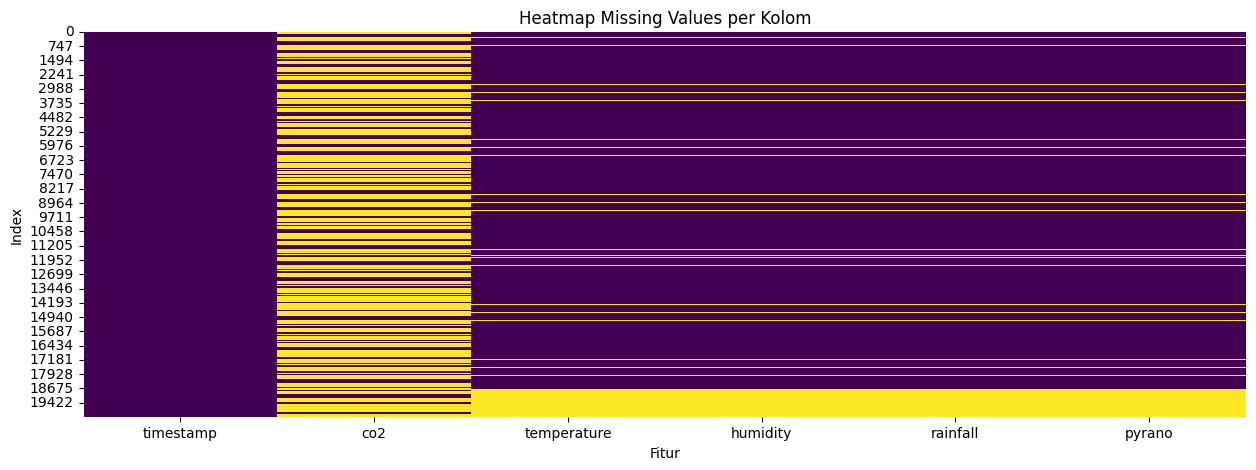

In [17]:
# Visualisasi missing values menggunakan heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap Missing Values per Kolom')
plt.xlabel('Fitur')
plt.ylabel('Index')
plt.show()

**Hasil dan Insight:**
- **Pola Horizontal:** Terlihat jelas adanya **garis-garis kuning horizontal** yang membentang pada kolom `temperature`, `humidity`, `rainfall`, dan `pyrano`. Ini adalah bukti visual yang sangat kuat bahwa keempat sensor ini mati atau gagal merekam data **secara bersamaan** dalam beberapa periode waktu.
- **Pola Sporadis:** Sebaliknya, kolom `co2` menunjukkan pola data hilang yang lebih acak atau sporadis, ditandai dengan garis-garis kuning yang tersebar di seluruh rentang waktu.
- **Data Lengkap:** Kolom `timestamp` berwarna gelap solid, yang secara visual mengonfirmasi bahwa kolom ini tidak memiliki data yang hilang.

### **Memvisualisasikan Distribusi dan Outlier Data**

- Histogram dibuat untuk setiap fitur numerik untuk memvisualisasikan sebaran atau distribusi nilainya.
- Boxplot dibuat untuk setiap fitur numerik untuk secara visual mengidentifikasi keberadaan *outlier* atau pencilan.

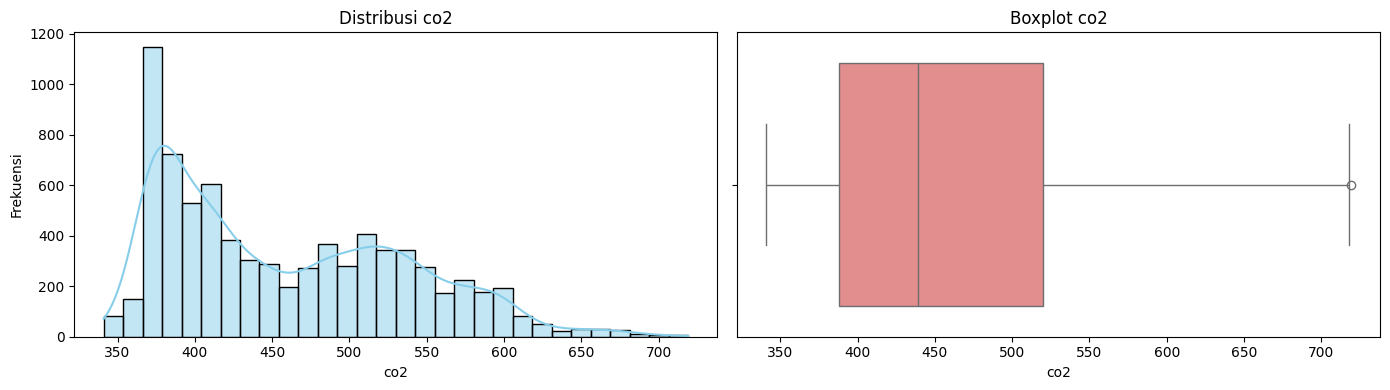

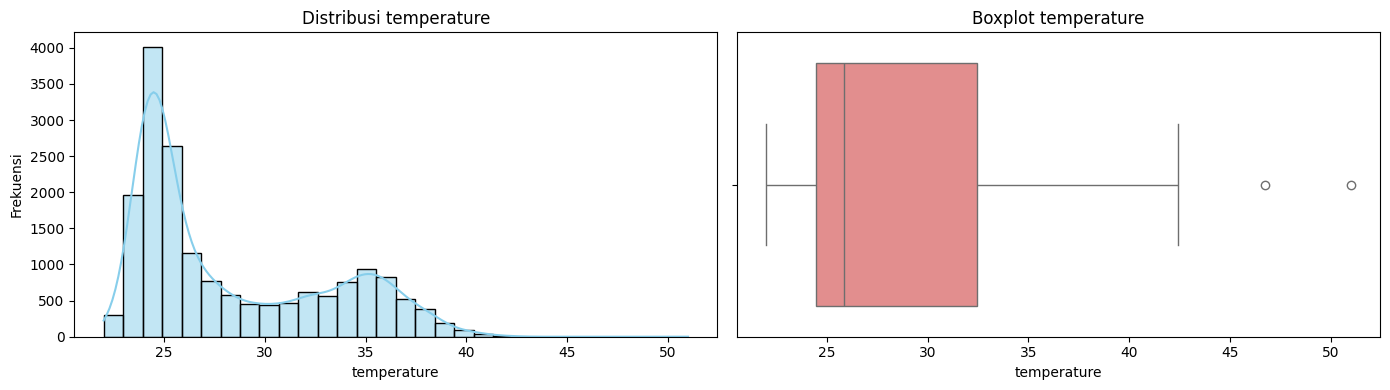

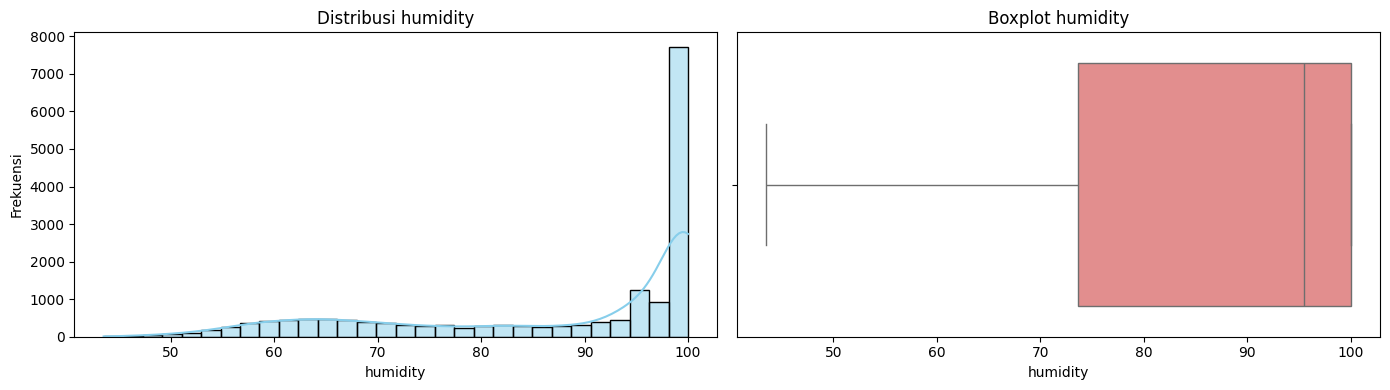

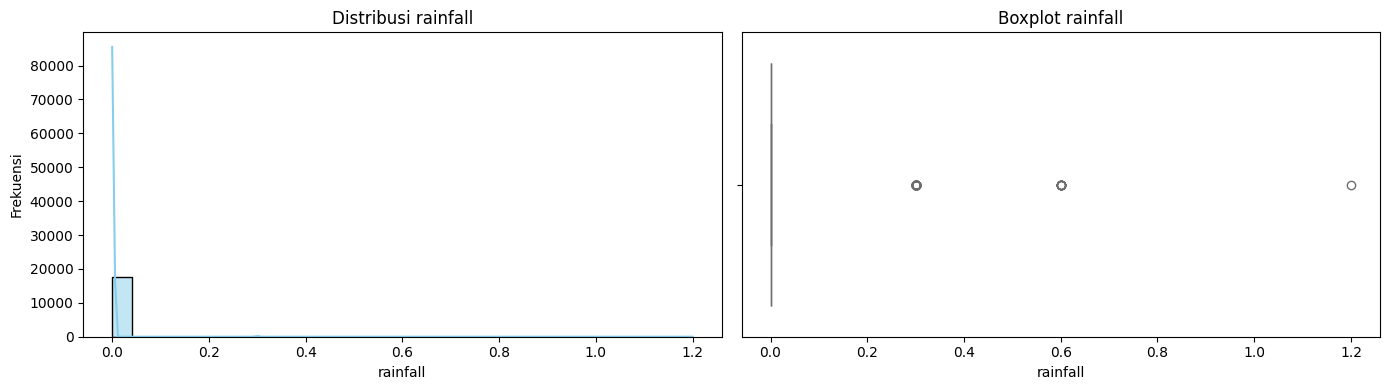

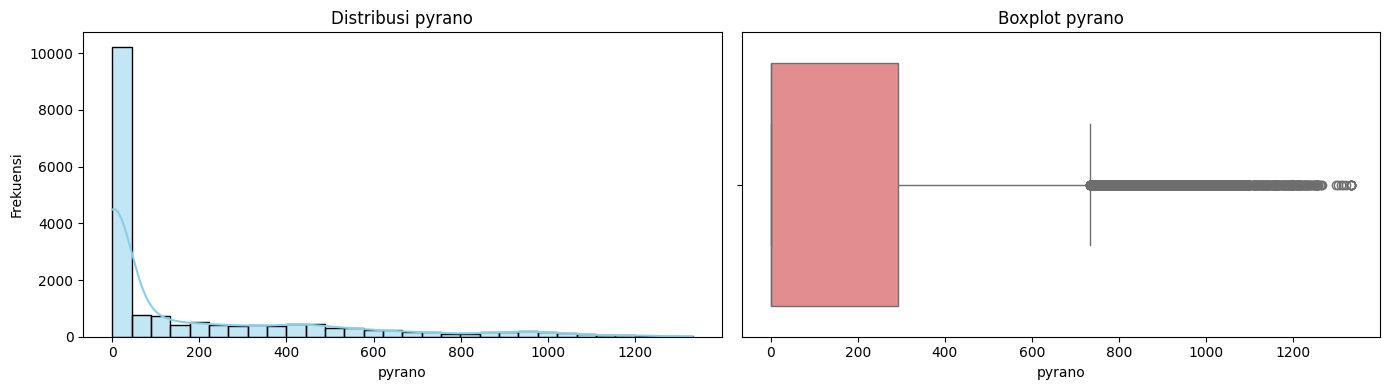

In [18]:
# Daftar kolom numerik yang akan divisualisasikan
num_cols = ['co2', 'temperature', 'humidity', 'rainfall', 'pyrano']

# Loop visualisasi histogram dan boxplot per kolom
for col in num_cols:
    plt.figure(figsize=(14, 4))

    # Histogram dengan KDE (Kernel Density Estimation)
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')

    # Boxplot untuk mendeteksi outlier
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='lightcoral')
    plt.title(f'Boxplot {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

**Hasil dan Insight:**

Bentuk distribusi dari setiap fitur memberikan wawasan penting tentang karakteristik data:
-   **`temperature` (Suhu):** Grafiknya menunjukkan **distribusi bimodal**, yang berarti ada dua puncak (puncak utama sekitar 25°C dan puncak kedua yang lebih kecil sekitar 35-40°C). Ini bisa menandakan adanya dua kondisi cuaca atau periode waktu yang dominan (misalnya, suhu di malam/pagi hari vs. suhu di siang hari).
-   **`humidity` (Kelembapan):** Distribusinya **sangat miring ke kiri (left-skewed)**. Sebagian besar data terkonsentrasi pada nilai kelembapan yang sangat tinggi (mendekati 100%), yang berarti kondisi lingkungan hampir selalu lembap.
-   **`pyrano` (Radiasi Matahari) & `rainfall` (Curah Hujan):** Kedua fitur ini menunjukkan distribusi yang **sangat miring ke kanan (right-skewed)**, dengan lonjakan besar pada nilai nol.
    -   Untuk **`pyrano`**, ini sangat wajar karena radiasi matahari bernilai nol sepanjang malam.
    -   Untuk **`rainfall`**, ini menunjukkan bahwa hujan adalah peristiwa yang jarang terjadi; sebagian besar waktu, tidak ada hujan yang tercatat.
-   **`co2`:** Distribusinya terlihat mendekati normal tetapi sedikit tidak teratur dan sedikit miring ke kanan. Ini menunjukkan bahwa nilai CO2 memiliki rentang yang cukup terpusat di sekitar nilai rata-ratanya.

### **Analisis Korelasi Antar Variabel**

Matriks korelasi dihitung untuk semua fitur numerik dan divisualisasikan menggunakan heatmap. Nilai dalam setiap sel menunjukkan koefisien korelasi Pearson, di mana +1 adalah korelasi positif sempurna, -1 adalah korelasi negatif sempurna, dan 0 berarti tidak ada korelasi linear.

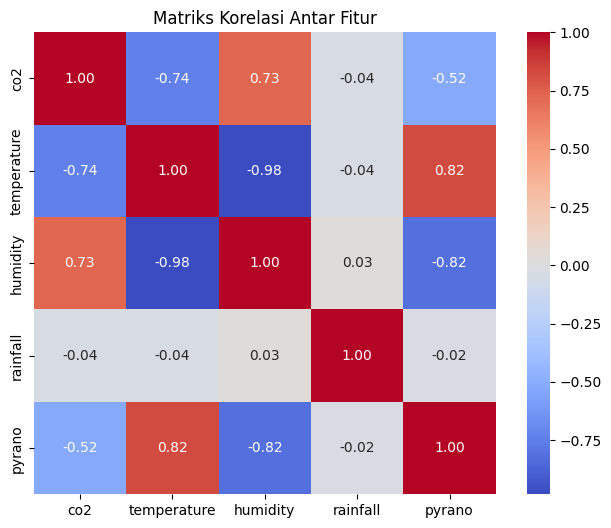

In [19]:
# Hitung korelasi antar fitur numerik (mengabaikan timestamp)
corr = df[['co2', 'temperature', 'humidity', 'rainfall', 'pyrano']].corr()

# Visualisasi matriks korelasi dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriks Korelasi Antar Fitur')
plt.show()

**Hasil dan Insight:**

Heatmap ini mengungkap beberapa hubungan penting antar variabel di dataset Anda:

-   **Korelasi Negatif Kuat (-0.78) antara `temperature` dan `humidity`:**
    Ini adalah hubungan paling kuat yang terdeteksi. Artinya, ada kecenderungan kuat bahwa **ketika suhu (`temperature`) meningkat, kelembapan (`humidity`) akan menurun**, dan sebaliknya. Ini adalah pola yang sangat umum di alam.

-   **Korelasi Positif Kuat (0.67) antara `temperature` dan `pyrano`:**
    Terdapat hubungan positif yang cukup kuat antara suhu dan radiasi matahari (`pyrano`). Ini sangat logis: **semakin tinggi radiasi matahari yang diterima, semakin tinggi pula suhunya**.

-   **Korelasi Negatif Kuat (-0.65) antara `humidity` dan `pyrano`:**
    Sejalan dengan dua poin sebelumnya, ada hubungan negatif yang kuat antara kelembapan dan radiasi matahari. **Saat radiasi matahari (`pyrano`) tinggi, kelembapan (`humidity`) cenderung rendah**.

-   **Korelasi Lemah:**
    Fitur `co2` dan `rainfall` menunjukkan korelasi yang sangat lemah (nilai mendekati 0) dengan fitur-fitur lainnya. Ini menandakan bahwa perubahan pada `co2` atau `rainfall` tidak memiliki hubungan linear yang jelas dengan perubahan suhu, kelembapan, atau radiasi matahari dalam dataset ini.

## **Pre-Processing**

### **Penanganan Missing Values**

Berdasarkan analisis `df.isnull().sum()`, kita menangani nilai yang hilang menggunakan metode `.ffill()` yang dilanjutkan dengan `.bfill()`. Kode yang dijalankan adalah `df_filled = df.ffill().bfill()`.

**Tujuan:**
Metode ini bekerja dalam dua tahap untuk memastikan tidak ada data yang kosong:
1.  **`.ffill()` (Forward Fill):** Mengisi setiap nilai yang hilang dengan nilai valid terakhir yang diketahui sebelumnya. Ini seperti "membawa" nilai terakhir ke depan sampai menemukan nilai baru.
2.  **`.bfill()` (Backward Fill):** Mengisi sisa nilai yang mungkin masih kosong (biasanya di awal dataset jika baris pertama sudah kosong) dengan nilai valid pertama *setelahnya*.

Kombinasi ini adalah strategi imputasi yang efektif dan lugas untuk mengisi semua celah dalam data.

In [20]:
df_filled = df.ffill().bfill()

Missing value diisi dengan nilai pada menit sebelumnya dan sesudahnya dengan asumsi bahwa data terekam secara kontinu, perubahan antar menit relatif stabil, serta tidak terdapat lonjakan nilai ekstrem dalam waktu singkat. Pendekatan ini sesuai untuk data sensor lingkungan yang cenderung memiliki pola halus dan bertahap.

In [21]:
df_filled.head(100)

,timestamp,co2,temperature,humidity,rainfall,pyrano
0,2025-04-24 00:00:00,519.0,24.450,100.0,0.0,0.0
1,2025-04-24 00:01:00,519.0,24.450,100.0,0.0,0.0
2,2025-04-24 00:02:00,519.0,24.450,100.0,0.0,0.0
3,2025-04-24 00:03:00,519.0,24.450,100.0,0.0,0.0
4,2025-04-24 00:04:00,519.0,24.469,100.0,0.0,0.0
...,...,...,...,...,...,...
95,2025-04-24 01:35:00,592.0,24.367,100.0,0.0,0.0
96,2025-04-24 01:36:00,592.0,24.380,100.0,0.0,0.0
97,2025-04-24 01:37:00,592.0,24.525,100.0,0.0,0.0
98,2025-04-24 01:38:00,592.0,24.495,100.0,0.0,0.0


### **Visualisasi Time Series CO2 (Setelah Imputasi)**

Setelah mengisi nilai yang hilang, kita memvisualisasikan data `co2` sebagai plot deret waktu (time series).

**Tujuan:**
Untuk melihat pola data dari waktu ke waktu setelah imputasi. Ini membantu kita secara visual mengidentifikasi tren, musiman, dan anomali atau lonjakan (spike) yang tidak wajar yang mungkin merupakan *outlier*.

<Axes: title={'center': 'CO2 Time Series'}>

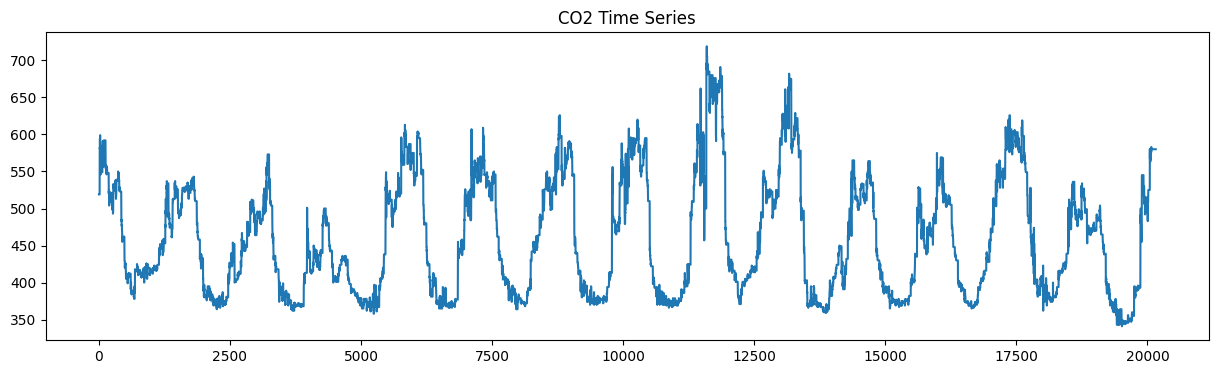

In [22]:
df_filled['co2'].plot(figsize=(15, 4), title='CO2 Time Series')

**Hasil dan Insight:**

Grafik time series `co2` menunjukkan pola siklus harian yang wajar. Namun, terlihat ada **satu lonjakan (spike) yang mencolok** di sekitar tanggal 2 Mei 2025, yang nilainya lebih tinggi dari puncak-puncak di sekitarnya. Lonjakan ini adalah kandidat kuat untuk *outlier* dan perlu diinvestigasi lebih lanjut.

### **Deteksi Outlier Menggunakan Metode IQR**

Kita mendefinisikan sebuah fungsi `detect_outliers_iqr` untuk menemukan outlier secara statistik. Metode ini menganggap sebuah titik data sebagai outlier jika berada di luar rentang 1.5 kali *Interquartile Range* (IQR) di bawah Kuartil 1 (Q1) atau di atas Kuartil 3 (Q3). Fungsi ini kemudian diterapkan pada kolom `co2`.

**Tujuan:**
Untuk mengonfirmasi secara kuantitatif keberadaan outlier yang sebelumnya kita curigai dari visualisasi.

In [23]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Contoh: deteksi outlier pada CO2
outlier_co2 = detect_outliers_iqr(df_filled, 'co2')
print(f"Jumlah outlier CO2: {len(outlier_co2)}")
outlier_co2.head()

Jumlah outlier CO2: 1


,timestamp,co2,temperature,humidity,rainfall,pyrano
11595,2025-05-02 01:15:00,719.0,24.071,100.0,0.0,0.0


**Hasil dan Insight:**

Metode IQR berhasil mendeteksi **1 outlier** pada data `co2`, yang sesuai dengan lonjakan yang kita lihat pada grafik time series.

### **Verifikasi Urutan Waktu Data**

Kita melakukan pengecekan integritas data dengan memastikan bahwa kolom `timestamp` sudah dalam format `datetime` dan terurut secara kronologis dari waktu terlama ke terbaru menggunakan atribut `.is_monotonic_increasing`.

**Tujuan:**
Langkah ini krusial. Analisis deret waktu, terutama saat membandingkan data "sebelum" dan "sesudah" sebuah titik waktu, hanya akan valid jika datanya berada dalam urutan waktu yang benar.

In [24]:
# Kalau timestamp masih kolom biasa
df_filled['timestamp'] = pd.to_datetime(df_filled['timestamp'])

# Cek apakah sudah urut naik
is_sorted = df_filled['timestamp'].is_monotonic_increasing
print(f"Timestamp sudah urut naik? {is_sorted}")

# Kalau belum, urutkan dulu
if not is_sorted:
    df = df_filled.sort_values(by='timestamp').reset_index(drop=True)
    print("Data sudah diurutkan berdasarkan timestamp.")


Timestamp sudah urut naik? True


**Hasil dan Insight:**

Output `Timestamp sudah urut naik? True` mengonfirmasi bahwa data kita sudah dalam urutan kronologis yang benar dan siap untuk analisis lebih lanjut.

### **Investigasi Konteks Outlier**

Sebelum memutuskan untuk menghapus atau mengubah outlier, kita perlu memahami konteksnya. Kita mengisolasi titik data outlier tersebut dan memeriksa nilai pada 1 menit sebelum dan 1 menit sesudahnya.

**Tujuan:**
Untuk menentukan apakah outlier tersebut adalah lonjakan data yang tidak masuk akal (misalnya, nilai melonjak dari 400 ke 4000 lalu kembali ke 400) atau hanya merupakan puncak dari sebuah tren naik yang wajar.

In [25]:
# Pastikan timestamp sudah jadi datetime dan data sudah urut
df_filled['timestamp'] = pd.to_datetime(df_filled['timestamp'])
df_filled = df_filled.sort_values(by='timestamp').reset_index(drop=True)

# Set timestamp sebagai index supaya lebih mudah slicing
df_filled.set_index('timestamp', inplace=True)

# Timestamp outlier yang mau dicek
outlier_time = pd.to_datetime('2025-05-02 01:15:00')

# Data sebelum outlier: cari timestamp terbesar yang kurang dari outlier_time
before = df_filled[df_filled.index < outlier_time].iloc[-1]

# Data sesudah outlier: cari timestamp terkecil yang lebih dari outlier_time
after = df_filled[df_filled.index > outlier_time].iloc[0]

# Data outlier (kalau ada persis)
outlier = df_filled.loc[df_filled.index == outlier_time]

print("Data 1 menit sebelum outlier:")
print(before)

print("\nData outlier:")
print(outlier if not outlier.empty else "Data outlier tidak ditemukan persis.")

print("\nData 1 menit sesudah outlier:")
print(after)


Data 1 menit sebelum outlier:
co2            718.000
temperature     24.199
humidity       100.000
rainfall         0.000
pyrano           0.000
Name: 2025-05-02 01:14:00, dtype: float64

Data outlier:
                       co2  temperature  humidity  rainfall  pyrano
timestamp                                                          
2025-05-02 01:15:00  719.0       24.071     100.0       0.0     0.0

Data 1 menit sesudah outlier:
co2            712.000
temperature     24.113
humidity       100.000
rainfall         0.000
pyrano           0.000
Name: 2025-05-02 01:16:00, dtype: float64


**Hasil dan Insight:** 
-   Data 1 menit sebelum outlier: `co2` = **718.0**
-   Data outlier: `co2` = **719.0**
-   Data 1 menit sesudah outlier: `co2` = **712.0**

Nilai outlier (719.0) hanya sedikit lebih tinggi dari nilai sebelumnya (718.0) dan tidak jauh berbeda dari nilai sesudahnya (712.0). Ini menunjukkan bahwa lonjakan tersebut **bukanlah kesalahan data yang ekstrem**, melainkan kemungkinan sebuah puncak pengukuran yang sah. Oleh karena itu, kita **memutuskan untuk tidak menghapus atau mengubah nilai ini**.

### **Normalisasi**

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols_to_scale = ['co2', 'temperature', 'humidity', 'rainfall', 'pyrano']

df_scaled = df_filled.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

# Jangan lupa reset index jika sebelumnya pakai timestamp sebagai index
df_scaled = df_scaled.reset_index()

print(df_scaled.head())

            timestamp       co2  temperature  humidity  rainfall  pyrano
0 2025-04-24 00:00:00  0.470899     0.084535       1.0       0.0     0.0
1 2025-04-24 00:01:00  0.470899     0.084535       1.0       0.0     0.0
2 2025-04-24 00:02:00  0.470899     0.084535       1.0       0.0     0.0
3 2025-04-24 00:03:00  0.470899     0.084535       1.0       0.0     0.0
4 2025-04-24 00:04:00  0.470899     0.085190       1.0       0.0     0.0


### **Hasil dan Insight:**

-   **Transformasi Berhasil:** Seperti yang terlihat pada output `.head()`, nilai pada kolom-kolom numerik telah berhasil diubah menjadi skala baru dalam **rentang 0 hingga 1**.
-   **Kolom Lain Aman:** Kolom non-numerik seperti `timestamp`, `hour`, dan `date` tidak ikut ternormalisasi dan nilainya tetap utuh, sesuai dengan yang diharapkan.
-   **Kesiapan Data:** Dengan semua fitur numerik berada pada skala yang sama, dataset kini berada dalam kondisi optimal. Tidak akan ada fitur yang mendominasi proses training model hanya karena memiliki rentang nilai yang lebih besar.

Dataset `df_scaled` ini adalah produk akhir dari seluruh proses pembersihan dan pra-pemrosesan. Data ini **sepenuhnya siap** untuk digunakan pada tahap selanjutnya, yaitu **pemodelan *machine learning***.

### **Menyimpan Data Bersih (Sebelum Normalisasi)**

Menyimpan DataFrame `df_filled` ke dalam file `dataset/data-clean/data_filled.csv`.

**Tujuan:**
Membuat sebuah *checkpoint* dari data yang sudah bersih dari *missing values* dan telah melalui analisis outlier. File ini berguna untuk arsip atau jika kita ingin mencoba metode normalisasi yang berbeda di kemudian hari.

In [27]:
output_filled_path = 'dataset/data-clean/data_filled.csv'
df_filled.to_csv(output_filled_path, index=False)
print(f"Data yang sudah ditangani missing value berhasil disimpan di: {output_filled_path}")

Data yang sudah ditangani missing value berhasil disimpan di: dataset/data-clean/data_filled.csv


**Hail dan Insight:**

Data bersih yang sudah ditangani namun belum di normalisasi tersimpan dengan nama dan lokasi dataset/data-clean/data_filled.csv

### **Menyimpan Data Final yang Siap untuk Model**

Menyimpan DataFrame `df_scaled` (data yang sudah dinormalisasi) ke dalam file `dataset/data-clean/data_scaled.csv`.

**Tujuan:**
Menghasilkan file data final yang telah sepenuhnya bersih, lengkap, dan siap untuk langsung digunakan pada tahap *modeling machine learning*.

In [28]:
output_scaled_path = 'dataset/data-clean/data_scaled.csv'
df_scaled.to_csv(output_scaled_path, index=False)
print(f"Data yang sudah dinormalisasi berhasil disimpan di: {output_scaled_path}")

Data yang sudah dinormalisasi berhasil disimpan di: dataset/data-clean/data_scaled.csv


**Hail dan Insight:**

Data bersih yang sudah ditangani dan sudah di normalisasi tersimpan dengan nama dan lokasi dataset/data-clean/data_scaled.csv

# **Pemodelan dan Evaluasi**

### **Import Library**

Langkah pertama dalam proyek ini adalah mengimpor berbagai library yang dibutuhkan untuk:
- Pemrosesan data (`pandas`, `numpy`)
- Pembagian data dan modeling (`train_test_split`, `SVR`, `RandomForestRegressor`, `xgboost`)
- Evaluasi model (`mean_absolute_error`, `mean_squared_error`, `r2_score`)
- Penyimpanan model (`joblib`)
- Visualisasi data dan hasil (`matplotlib`)

In [29]:
# Impor library untuk manipulasi dan analisis data
import pandas as pd
import numpy as np

# Impor library untuk pembagian data dan model machine learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR  # SVR adalah implementasi Support Vector Machine untuk regresi
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb  # Pastikan xgboost sudah terinstal: pip install xgboost

# Impor library untuk evaluasi performa model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Impor library tambahan untuk penyimpanan model dan visualisasi
import joblib  # Untuk menyimpan model dalam file
import os
import matplotlib.pyplot as plt  # Untuk membuat visualisasi grafik

### **Memuat dan Verifikasi Data**

Kita memuat dataset `data_scaled.csv` yang merupakan output dari notebook pra-pemrosesan. Setelah dimuat, kita langsung melakukan verifikasi cepat dengan memeriksa dimensi (`.shape`) dan ringkasan teknis (`.info()`) dari data tersebut.

**Tujuan:**
Untuk memastikan data yang sudah bersih dan ternormalisasi berhasil dimuat dengan benar dan untuk melakukan pengecekan terakhir terhadap struktur dan kualitasnya sebelum masuk ke tahap *feature engineering*.

In [30]:
# Load dataset dari Google Drive
df = pd.read_csv('dataset/data-clean/data_scaled.csv')

# Tampilkan dimensi dataset
print(f"Shape dataset: {df.shape}")# Tampilkan informasi umum dari dataset
print("Info dataset")
df.info()

Shape dataset: (20160, 6)
Info dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    20160 non-null  object 
 1   co2          20160 non-null  float64
 2   temperature  20160 non-null  float64
 3   humidity     20160 non-null  float64
 4   rainfall     20160 non-null  float64
 5   pyrano       20160 non-null  float64
dtypes: float64(5), object(1)
memory usage: 945.1+ KB


**Hasil dan Insight:**
-   **Dimensi Data:** Dataset berhasil dimuat dan memiliki **20,160 baris** dan **6 kolom**, sesuai dengan yang diharapkan.
-   **Kualitas Data Terverifikasi:** Output `.info()` menunjukkan bahwa semua kolom memiliki **20,160 nilai non-null**. Ini adalah konfirmasi penting bahwa data kita sudah **bersih dari *missing values***.
-   **Tipe Data:** Kolom `timestamp` saat ini terbaca sebagai tipe `object`. Ini perlu kita ubah kembali menjadi format `datetime` agar bisa digunakan untuk analisis berbasis waktu lebih lanjut. Fitur numerik lainnya sudah dalam format `float64` yang benar.

### **Penyesuaian Indeks Waktu (Datetime Index)**

Pada tahap ini, kita melakukan beberapa persiapan krusial pada DataFrame:
1.  **Membuat Salinan:** Menyalin DataFrame asli ke `df_original` sebagai cadangan.
2.  **Konversi Tipe Data:** Mengubah kolom `timestamp` dari tipe `object` menjadi `datetime`.
3.  **Set Index:** Menjadikan kolom `timestamp` yang sudah berformat `datetime` sebagai *index* utama dari DataFrame.

**Tujuan:**
Mengubah indeks DataFrame menjadi `DatetimeIndex` adalah praktik terbaik untuk analisis deret waktu. Ini memberikan kita kemampuan super untuk melakukan berbagai operasi berbasis waktu dengan sangat mudah, seperti:
-   Memilih data dalam rentang waktu tertentu (misalnya, `df['2025-05-01']`).
-   Melakukan *resampling* data (misalnya, mengubah data per menit menjadi per jam).
-   Membuat plot deret waktu secara otomatis.

In [31]:
# Salin dataframe untuk menjaga agar data asli tidak termodifikasi
df_original = df.copy()

In [32]:
# Mengubah kolom 'timestamp' menjadi format datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [33]:
# Menjadikan 'timestamp' sebagai index dataframe
df = df.set_index('timestamp')

In [34]:
# Tampilkan 5 baris pertama dari data setelah di-set index
print("Data awal (5 baris pertama):")
display(df.head())

Data awal (5 baris pertama):


,co2,temperature,humidity,rainfall,pyrano
timestamp,,,,,
2025-04-24 00:00:00,0.470899,0.084535,1.0,0.0,0.0
2025-04-24 00:01:00,0.470899,0.084535,1.0,0.0,0.0
2025-04-24 00:02:00,0.470899,0.084535,1.0,0.0,0.0
2025-04-24 00:03:00,0.470899,0.084535,1.0,0.0,0.0
2025-04-24 00:04:00,0.470899,0.085190,1.0,0.0,0.0


In [35]:
# Tampilkan informasi struktur dataframe
print("\nInformasi DataFrame:")
display(df.info())


Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20160 entries, 2025-04-24 00:00:00 to 2025-05-07 23:59:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   co2          20160 non-null  float64
 1   temperature  20160 non-null  float64
 2   humidity     20160 non-null  float64
 3   rainfall     20160 non-null  float64
 4   pyrano       20160 non-null  float64
dtypes: float64(5)
memory usage: 945.0 KB


None

**Hasil dan Insight:** 
-   `df.head()` secara visual mengonfirmasi bahwa kolom `timestamp` kini telah menjadi label indeks di sebelah kiri.
-   `df.info()` memberikan konfirmasi teknis: Tipe indeks telah berubah dari `RangeIndex` menjadi **`DatetimeIndex`**. Jumlah kolom data juga berkurang menjadi 5, karena `timestamp` tidak lagi dihitung sebagai kolom data, melainkan sebagai index.
-   DataFrame kita sekarang sudah terstruktur dengan benar dan siap untuk proses *feature engineering* yang spesifik untuk data deret waktu.

### **Visualisasi Data Deret Waktu**

Setelah mengatur `timestamp` sebagai indeks, kita membuat plot garis (*line plot*) untuk melihat pergerakan data `co2` dari waktu ke waktu.

**Tujuan:**
Untuk mendapatkan pemahaman visual mengenai karakteristik data deret waktu kita. Visualisasi ini membantu kita mengidentifikasi pola-pola penting seperti:
-   **Tren:** Apakah data cenderung naik atau turun dalam jangka panjang?
-   **Musiman/Siklus:** Apakah ada pola yang berulang secara periodik (misalnya, harian, mingguan)?
-   **Anomali:** Apakah ada lonjakan atau penurunan data yang tidak wajar?

VISUALISASI DATA AWAL


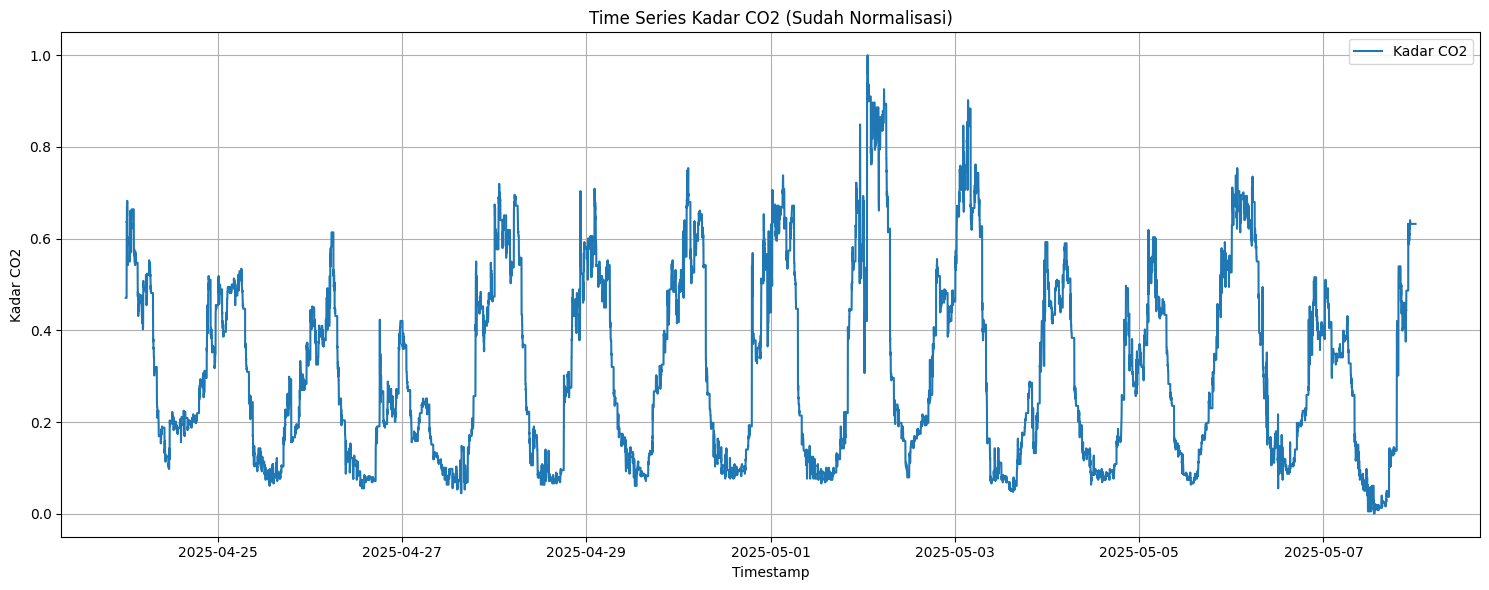

In [36]:
print("VISUALISASI DATA AWAL")
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['co2'], label='Kadar CO2')
plt.title('Time Series Kadar CO2 (Sudah Normalisasi)')
plt.xlabel('Timestamp')
plt.ylabel('Kadar CO2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Hasil dan Insight:**
-   **Pola Siklus Harian (Diurnal Cycle):** Grafik dengan jelas menunjukkan adanya **pola siklus yang berulang setiap hari**. Terlihat ada puncak dan lembah yang terjadi pada waktu yang kurang lebih sama setiap harinya. Ini adalah sinyal yang sangat kuat dalam data.
-   **Stasioneritas Tren:** Dalam rentang waktu yang ditampilkan, tidak terlihat adanya tren jangka panjang yang signifikan (data tidak terus-menerus naik atau turun).
-   **Potensi Prediksi:** Adanya pola siklus harian yang kuat ini adalah kabar baik. Ini menandakan bahwa perilaku data di masa lalu adalah prediktor yang baik untuk perilaku data di masa depan. Model *machine learning* seharusnya dapat mempelajari pola ini untuk membuat prediksi yang akurat.

### **Rekayasa Fitur (Feature Engineering) untuk Deret Waktu**

Ini adalah langkah paling inti dalam mempersiapkan data deret waktu untuk model regresi. Kita melakukan tiga hal:
1.  **Mendefinisikan Target Prediksi:** Kita membuat dua kolom target baru, `co2_target_1min` dan `co2_target_1hour`, dengan menggunakan `.shift()` untuk "menarik" nilai CO2 dari masa depan (1 menit dan 60 menit ke depan) ke baris saat ini.
2.  **Membuat Fitur Lag:** Kita membuat 10 fitur baru (`co2_lag_1` hingga `co2_lag_10`) yang berisi nilai CO2 dari waktu-waktu sebelumnya. Ini memberikan "memori" jangka pendek pada model.
3.  **Menggabungkan Fitur:** Semua fitur lag digabungkan dengan fitur eksogen (suhu, kelembapan, dll.) untuk membentuk satu set fitur prediktor yang lengkap.

**Tujuan:**
Untuk mengubah masalah deret waktu menjadi format *supervised learning* klasik. Model akan belajar memprediksi `y` (target masa depan) berdasarkan `X` (kombinasi data masa lalu dan data eksternal saat ini).

In [37]:
# Definisikan kolom target dan fitur eksogen
target_column = 'co2'
exog_features = ['temperature', 'humidity', 'rainfall', 'pyrano']

# Buat target prediksi: 1 menit ke depan dan 1 jam ke depan
df['co2_target_1min'] = df[target_column].shift(-1)
df['co2_target_1hour'] = df[target_column].shift(-60)

In [38]:
# Buat fitur lag (CO2 sebelumnya)
n_lags = 10
lag_cols = []

for i in range(1, n_lags + 1):
    col_name = f'{target_column}_lag_{i}'
    df[col_name] = df[target_column].shift(i)
    lag_cols.append(col_name)

# Gabungkan fitur lag dan fitur eksogen
feature_columns = lag_cols + exog_features
print(f"\nKolom fitur yang akan digunakan: {feature_columns}")


Kolom fitur yang akan digunakan: ['co2_lag_1', 'co2_lag_2', 'co2_lag_3', 'co2_lag_4', 'co2_lag_5', 'co2_lag_6', 'co2_lag_7', 'co2_lag_8', 'co2_lag_9', 'co2_lag_10', 'temperature', 'humidity', 'rainfall', 'pyrano']


**Hasil dan Insight:**

Outputnya menampilkan daftar 14 kolom fitur yang akan menjadi "pengetahuan" bagi model kita untuk membuat prediksi.

### **Membersihkan dan Memisahkan Data Final**

1.  **Menangani NaN:** Operasi `.shift()` secara otomatis menghasilkan nilai `NaN` di baris awal (untuk fitur lag) dan baris akhir (untuk fitur target). Baris-baris yang tidak lengkap ini tidak bisa digunakan untuk melatih model, sehingga kita menghapusnya menggunakan `.dropna()`.
2.  **Memisahkan Fitur (X) dan Target (y):** Setelah data bersih, kita memisahkannya menjadi matriks fitur (`X`) dan vektor target (`y`) untuk masing-masing skenario (1 menit dan 1 jam).

**Tujuan:**
Untuk menghasilkan set data `X` dan `y` yang bersih, lengkap, dan siap untuk dibagi menjadi data latih dan data uji pada langkah berikutnya.

In [39]:
# Siapkan data untuk model prediksi 1 menit
df_1min = df.dropna(subset=['co2_target_1min'] + feature_columns).copy()
X_1min_all = df_1min[feature_columns]
y_1min_all = df_1min['co2_target_1min']

In [40]:
# Siapkan data untuk model prediksi 1 jam
df_1hour = df.dropna(subset=['co2_target_1hour'] + feature_columns).copy()
X_1hour_all = df_1hour[feature_columns]
y_1hour_all = df_1hour['co2_target_1hour']

In [41]:
# Tampilkan informasi dimensi hasil feature enginering
print(f"\nJumlah data setelah feature enginering (1 menit): {len(df_1min)}")
print(f"Shape X_1min_all: {X_1min_all.shape}, Shape y_1min_all: {y_1min_all.shape}")

print(f"Jumlah data setelah feature enginering (1 jam): {len(df_1hour)}")
print(f"Shape X_1hour_all: {X_1hour_all.shape}, Shape y_1hour_all: {y_1hour_all.shape}")


Jumlah data setelah feature enginering (1 menit): 20149
Shape X_1min_all: (20149, 14), Shape y_1min_all: (20149,)
Jumlah data setelah feature enginering (1 jam): 20090
Shape X_1hour_all: (20090, 14), Shape y_1hour_all: (20090,)


**Hasil dan Insight:**
-   Output menunjukkan jumlah data yang tersisa untuk setiap skenario setelah dibersihkan.
-   Terdapat lebih sedikit data untuk prediksi 1 jam (20,090) dibandingkan 1 menit (20,149). Ini karena `shift(-60)` menyebabkan 60 baris terakhir tidak memiliki target, sehingga lebih banyak baris yang dihapus.

### **Validasi Ketersediaan Data**

Kita melakukan sebuah pengecekan sederhana untuk memastikan bahwa DataFrame fitur (`X_1min_all` dan `X_1hour_all`) tidak kosong setelah proses pembersihan.

**Tujuan:**
Ini adalah langkah *defensive programming* atau "jaga-jaga". Tujuannya adalah untuk menghentikan eksekusi jika terjadi kesalahan pada langkah sebelumnya yang menyebabkan semua data terhapus, sehingga mencegah *error* pada langkah-langkah pemodelan selanjutnya.

In [42]:
# Validasi ketersediaan data
if X_1min_all.empty or X_1hour_all.empty:
    print("Error: Tidak ada data tersisa setelah rekayasa fitur.")
    exit()

**Hasil dan Insight:**

Tidak ada pesan error yang muncul, yang berarti validasi berhasil dan kita memiliki data yang cukup untuk melanjutkan ke tahap pemodelan.

### **Pembagian Data (Train-Test Split)**

Kita menggunakan fungsi `train_test_split` dari Scikit-learn untuk membagi setiap set data (`1min` dan `1hour`) menjadi dua bagian:
-   **Data Latih (Training Set):** 80% dari data.
-   **Data Uji (Test Set):** 20% dari data.

**Tujuan:**
Tujuan utama dari pembagian ini adalah untuk evaluasi model yang objektif. Model akan "belajar" dari `training set`. Setelah itu, performanya akan diuji pada `test set` untuk mensimulasikan bagaimana model akan beraksi terhadap data baru yang belum pernah dilihat sebelumnya.

In [43]:
# Pembagian data untuk model prediksi 1 menit ke depan
X_train_1min, X_test_1min, y_train_1min, y_test_1min = train_test_split(
    X_1min_all, y_1min_all, test_size=0.2, shuffle=False
)

print(f"Jumlah data latih (1 menit): {len(X_train_1min)}")
print(f"Jumlah data uji   (1 menit): {len(X_test_1min)}")

Jumlah data latih (1 menit): 16119
Jumlah data uji   (1 menit): 4030


In [44]:
# Pembagian data untuk model prediksi 1 jam ke depan
X_train_1hour, X_test_1hour, y_train_1hour, y_test_1hour = train_test_split(
    X_1hour_all, y_1hour_all, test_size=0.2, shuffle=False
)

print(f"Jumlah data latih (1 jam): {len(X_train_1hour)}")
print(f"Jumlah data uji   (1 jam): {len(X_test_1hour)}")

Jumlah data latih (1 jam): 16072
Jumlah data uji   (1 jam): 4018


**Hasil dan Insight Penting:** 

- Parameter **`shuffle=False`** sangat krusial di sini. Karena kita bekerja dengan data deret waktu, urutan data sangatlah penting. Dengan `shuffle=False`, kita memastikan data tidak diacak. Pembagian dilakukan secara kronologis: data yang lebih lama (80% pertama) menjadi data latih, dan data yang lebih baru (20% terakhir) menjadi data uji. Ini meniru skenario dunia nyata di mana kita melatih model pada data historis untuk memprediksi masa depan.
- Output menunjukkan jumlah baris data yang dialokasikan untuk setiap set (latih dan uji) pada kedua skenario (1 menit dan 1 jam), sesuai dengan rasio 80:20 yang telah kita tentukan.

### **Persiapan untuk Pelatihan dan Evaluasi**

Pada tahap ini, kita melakukan dua persiapan penting sebelum memulai *loop* pelatihan model:
1.  **Menyiapkan "Wadah" Penyimpanan:** Kita membuat dua buah *dictionary* kosong, yaitu `evaluation_results_storage` dan `trained_models_storage`.
2.  **Membuat Fungsi Plotting:** Kita mendefinisikan sebuah fungsi `plot_actual_vs_predicted` yang dapat digunakan kembali untuk membuat plot perbandingan antara nilai aktual dan nilai prediksi dari model.

**Tujuan:**
Langkah ini bertujuan untuk membuat alur kerja menjadi lebih terstruktur dan efisien:
-   *Dictionary* akan berfungsi sebagai tempat penyimpanan yang rapi untuk semua hasil metrik evaluasi dan objek model yang telah dilatih, sehingga mudah untuk diakses dan dibandingkan nanti.
-   Fungsi `plot_actual_vs_predicted` dibuat agar kita tidak perlu menulis kode visualisasi yang sama berulang kali untuk setiap model. Ini membuat kode lebih bersih dan konsisten.

In [45]:
# Menyiapkan storage untuk hasil evaluasi dan model hasil training
evaluation_results_storage = {"1_min": {}, "1_hour": {}}
trained_models_storage = {"1_min": {}, "1_hour": {}}

# Fungsi untuk mem-plot nilai aktual vs hasil prediksi dari model
def plot_actual_vs_predicted(y_true, y_pred, model_name, horizon_tag, test_index):
    plt.figure(figsize=(15, 6))
    plt.plot(test_index, y_true, label='Nilai Aktual CO2 (Test Set)', color='blue')
    plt.plot(test_index, y_pred, label=f'Prediksi {model_name} (Test Set)', color='red', linestyle='--')
    plt.title(f'Perbandingan Aktual vs Prediksi ({model_name}) - {horizon_tag}')
    plt.xlabel('Timestamp')
    plt.ylabel('Kadar CO2 (Scaled)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Hasil dan Insight:**

Cell ini tidak menghasilkan output visual, tetapi setelah dieksekusi, kita memiliki semua variabel dan fungsi yang diperlukan untuk memulai proses pelatihan dan evaluasi model secara sistematis.

### **Prediksi 1 menit Ke Depan**

### **Inisiasi untuk prediksi 1 menit**

In [46]:
horizon_tag_1min = "1 Menit"

### **Pelatihan dan Evaluasi - Model SVM Regressor (1 Menit)**

Ini adalah langkah pertama dalam siklus inti *machine learning*. Untuk model **SVM Regressor** pada skenario prediksi **1 menit**, kita melakukan:
1.  **Inisialisasi Model:** Membuat instance dari model `SVR` dengan kernel `rbf`.
2.  **Pelatihan (Fit):** Melatih model menggunakan data latih.
3.  **Prediksi (Predict):** Menggunakan model untuk membuat prediksi pada data uji.
4.  **Evaluasi:** Menghitung metrik performa (MAE, MSE, RMSE, R²).
5.  **Penyimpanan & Visualisasi:** Menyimpan hasil dan memvisualisasikan perbandingan prediksi vs. aktual.

**Tujuan:**
Untuk melatih dan mendapatkan *benchmark* performa pertama dari model SVM Regressor. Hasil ini akan menjadi dasar perbandingan dengan model-model lain.

Model: SVM Regressor (1 Menit)
Melatih SVM Regressor


Mengevaluasi SVM Regressor
Hasil Evaluasi SVM Regressor (1 Menit):
MAE: 0.0509, MSE: 0.0047, RMSE: 0.0689, R2 Score: 0.8845


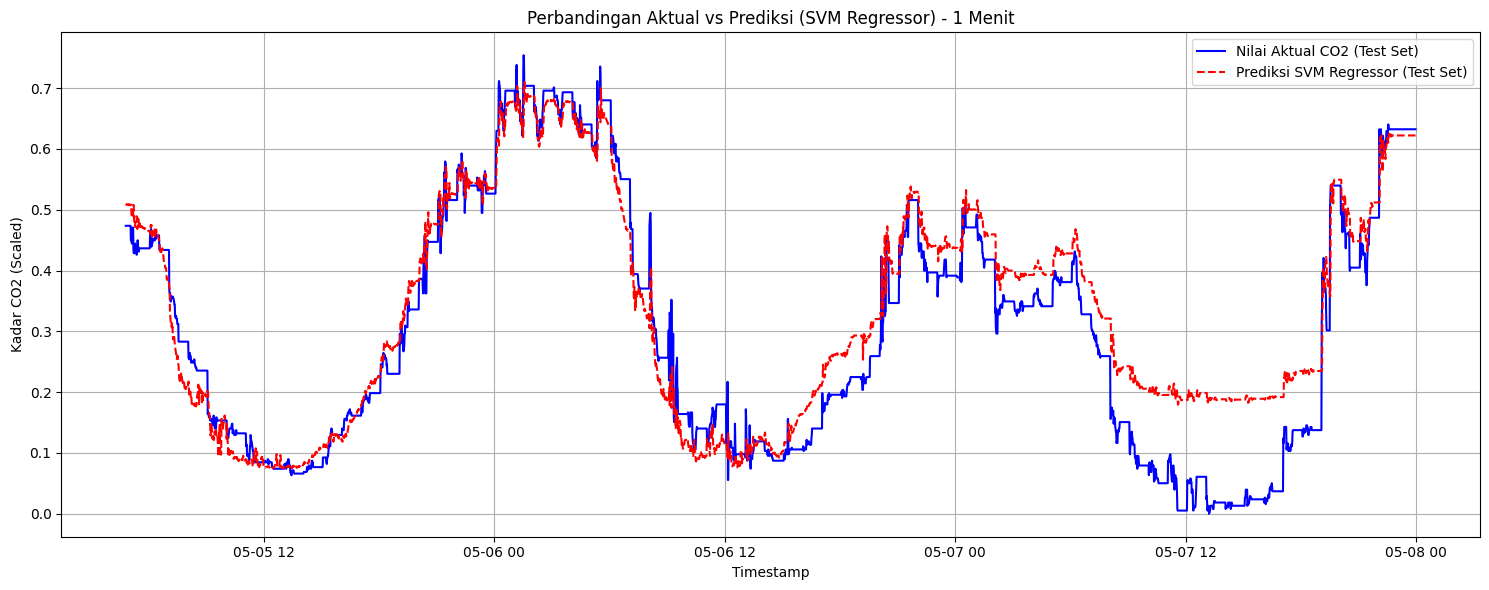

In [47]:
# --- Model SVM Regressor ---
model_name_svm = "SVM Regressor"
print(f"Model: {model_name_svm} ({horizon_tag_1min})")

# Inisialisasi model SVM dengan kernel RBF
svm_model_1min = SVR(kernel='rbf')

# Melatih model pada data training
print(f"Melatih {model_name_svm}")
svm_model_1min.fit(X_train_1min, y_train_1min)

# Simpan model terlatih
trained_models_storage["1_min"][model_name_svm] = svm_model_1min

# Prediksi pada data test
print(f"Mengevaluasi {model_name_svm}")
predictions_svm_1min = svm_model_1min.predict(X_test_1min)

# Hitung metrik evaluasi
mae_svm_1min = mean_absolute_error(y_test_1min, predictions_svm_1min)
mse_svm_1min = mean_squared_error(y_test_1min, predictions_svm_1min)
rmse_svm_1min = np.sqrt(mse_svm_1min)
r2_svm_1min = r2_score(y_test_1min, predictions_svm_1min)

# Simpan hasil evaluasi
evaluation_results_storage["1_min"][model_name_svm] = {
    "MAE": mae_svm_1min, "MSE": mse_svm_1min, "RMSE": rmse_svm_1min, "R2": r2_svm_1min
}

# Cetak hasil evaluasi
print(f"Hasil Evaluasi {model_name_svm} ({horizon_tag_1min}):")
print(f"MAE: {mae_svm_1min:.4f}, MSE: {mse_svm_1min:.4f}, RMSE: {rmse_svm_1min:.4f}, R2 Score: {r2_svm_1min:.4f}")

# Visualisasi hasil prediksi vs aktual
plot_actual_vs_predicted(y_test_1min, predictions_svm_1min, model_name_svm, horizon_tag_1min, X_test_1min.index)

**Hasil dan Insight:**

-   **Analisis Metrik:**
    -   Nilai **MAE**, **MSE**, dan **RMSE** yang dihasilkan sangat rendah (mendekati 0), menandakan bahwa rata-rata kesalahan prediksi model ini kecil.
    -   Skor **R² sebesar 0.8845** adalah hasil yang sangat baik. Ini berarti model SVR mampu menjelaskan sekitar **88.5%** dari variabilitas data CO2 pada test set.

-   **Analisis Visual:**
    -   Grafik perbandingan menunjukkan bahwa garis prediksi (merah putus-putus) mampu **mengikuti pola garis aktual (biru) dengan sangat baik**.
    -   Model berhasil menangkap **pola siklus harian** (naik-turunnya CO2) yang ada pada data. Meskipun ada sedikit perbedaan pada beberapa puncak dan lembah, secara keseluruhan prediksinya sangat akurat.

### **Pelatihan dan Evaluasi - Model Random Forest (1 Menit)**

Kita mengulangi siklus pelatihan dan evaluasi, kali ini untuk model **Random Forest Regressor**. Model ini bekerja dengan membangun banyak "pohon keputusan" secara acak dan kemudian merata-ratakan hasil prediksi dari semua pohon tersebut untuk menghasilkan prediksi akhir yang lebih stabil dan akurat.

**Tujuan:**
Untuk melatih dan mengevaluasi model kedua kita, serta membandingkan performanya secara langsung dengan *benchmark* yang telah ditetapkan oleh model SVR.

Model: RandomForest (1 Menit)
Melatih RandomForest
Mengevaluasi RandomForest
Hasil Evaluasi RandomForest (1 Menit):
MAE: 0.0225, MSE: 0.0014, RMSE: 0.0381, R2 Score: 0.9647


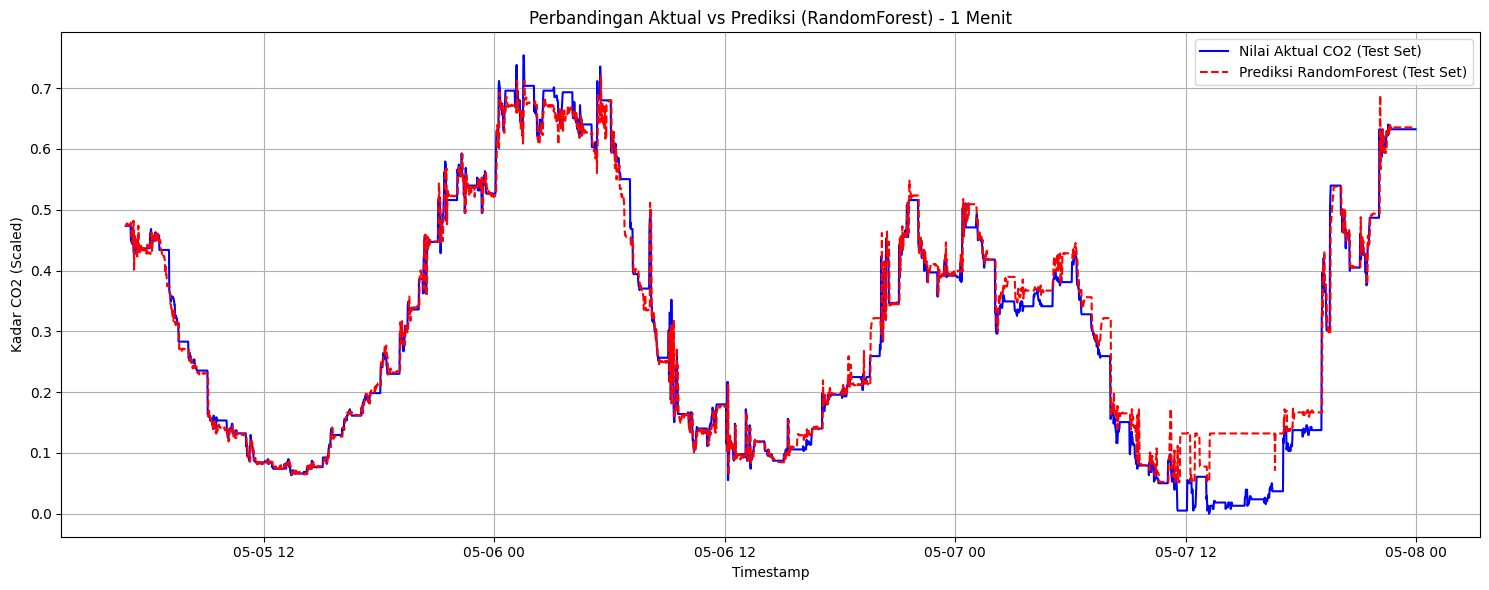

In [48]:
# --- Model Random Forest ---
model_name_rf = "RandomForest"
print(f"Model: {model_name_rf} ({horizon_tag_1min})")

# Inisialisasi model Random Forest
rf_model_1min = RandomForestRegressor(random_state=42, n_estimators=100)

# Melatih model
print(f"Melatih {model_name_rf}")
rf_model_1min.fit(X_train_1min, y_train_1min)

# Simpan model
trained_models_storage["1_min"][model_name_rf] = rf_model_1min

# Prediksi pada data test
print(f"Mengevaluasi {model_name_rf}")
predictions_rf_1min = rf_model_1min.predict(X_test_1min)

# Evaluasi model
mae_rf_1min = mean_absolute_error(y_test_1min, predictions_rf_1min)
mse_rf_1min = mean_squared_error(y_test_1min, predictions_rf_1min)
rmse_rf_1min = np.sqrt(mse_rf_1min)
r2_rf_1min = r2_score(y_test_1min, predictions_rf_1min)

# Simpan hasil evaluasi
evaluation_results_storage["1_min"][model_name_rf] = {
    "MAE": mae_rf_1min, "MSE": mse_rf_1min, "RMSE": rmse_rf_1min, "R2": r2_rf_1min
}

# Cetak hasil evaluasi
print(f"Hasil Evaluasi {model_name_rf} ({horizon_tag_1min}):")
print(f"MAE: {mae_rf_1min:.4f}, MSE: {mse_rf_1min:.4f}, RMSE: {rmse_rf_1min:.4f}, R2 Score: {r2_rf_1min:.4f}")

# Visualisasi hasil prediksi
plot_actual_vs_predicted(y_test_1min, predictions_rf_1min, model_name_rf, horizon_tag_1min, X_test_1min.index)

**Hasil dan Insight:**

-   **Analisis Metrik:**
    -   Model Random Forest menghasilkan skor **R² sebesar 0.9647**. Ini adalah hasil yang luar biasa, yang berarti model ini mampu menjelaskan sekitar **96.5%** dari variabilitas data CO2.
    -   Nilai *error* (MAE, MSE, RMSE) juga terlihat lebih rendah dibandingkan model SVR

-   **Analisis Visual:**
    -   Grafik perbandingan secara visual mengonfirmasi keunggulan ini. Garis prediksi (merah putus-putus) terlihat "menempel" sangat erat pada garis nilai aktual (biru), bahkan pada fluktuasi-fluktuasi kecil sekalipun.

### **Pelatihan dan Evaluasi - Model XGBoost (1 Menit)**

Kita melatih dan mengevaluasi kandidat model ketiga, **XGBoost (Extreme Gradient Boosting)**. XGBoost adalah model *ensemble* yang sangat populer dan kuat, yang membangun model secara bertahap untuk terus menerus memperbaiki kesalahan dari model sebelumnya.

**Tujuan**
Untuk melatih dan menguji performa model XGBoost serta membandingkannya dengan hasil dari SVR dan Random Forest untuk menentukan model terbaik secara keseluruhan.

Model: XGBoost (1 Menit)
Melatih XGBoost
Mengevaluasi XGBoost
Hasil Evaluasi XGBoost (1 Menit):
MAE: 0.0271, MSE: 0.0027, RMSE: 0.0524, R2 Score: 0.9333


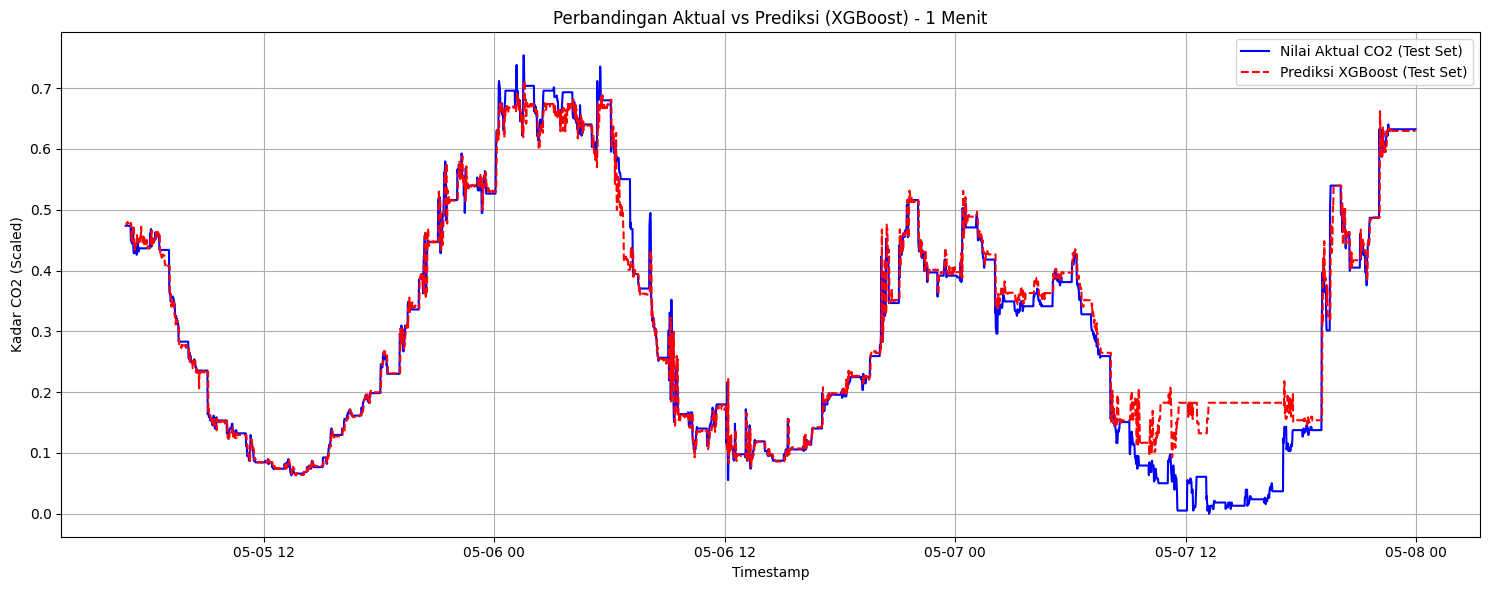

In [49]:
# --- Model XGBoost ---
model_name_xgb = "XGBoost"
print(f"Model: {model_name_xgb} ({horizon_tag_1min})")

# Inisialisasi model XGBoost Regressor
xgb_model_1min = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)

# Training model
print(f"Melatih {model_name_xgb}")
xgb_model_1min.fit(X_train_1min, y_train_1min)

# Simpan model
trained_models_storage["1_min"][model_name_xgb] = xgb_model_1min

# Prediksi data test
print(f"Mengevaluasi {model_name_xgb}")
predictions_xgb_1min = xgb_model_1min.predict(X_test_1min)

# Evaluasi performa
mae_xgb_1min = mean_absolute_error(y_test_1min, predictions_xgb_1min)
mse_xgb_1min = mean_squared_error(y_test_1min, predictions_xgb_1min)
rmse_xgb_1min = np.sqrt(mse_xgb_1min)
r2_xgb_1min = r2_score(y_test_1min, predictions_xgb_1min)

# Simpan hasil evaluasi
evaluation_results_storage["1_min"][model_name_xgb] = {
    "MAE": mae_xgb_1min, "MSE": mse_xgb_1min, "RMSE": rmse_xgb_1min, "R2": r2_xgb_1min
}

# Tampilkan metrik evaluasi
print(f"Hasil Evaluasi {model_name_xgb} ({horizon_tag_1min}):")
print(f"MAE: {mae_xgb_1min:.4f}, MSE: {mse_xgb_1min:.4f}, RMSE: {rmse_xgb_1min:.4f}, R2 Score: {r2_xgb_1min:.4f}")

# Visualisasi hasil prediksi
plot_actual_vs_predicted(y_test_1min, predictions_xgb_1min, model_name_xgb, horizon_tag_1min, X_test_1min.index)

**Hasil dan Insight:**

-   **Analisis Metrik**
    -   Model XGBoost mencapai skor **R² sebesar 0.9333**, yang menunjukkan performa yang sangat baik dan akurat. Model ini mampu menjelaskan sekitar **93.3%** dari variabilitas data.
    -   Nilai *error* (MAE, MSE, RMSE) yang dihasilkan juga sangat rendah.

-   **Analisis Visual**
    -   Sama seperti Random Forest, grafik XGBoost menunjukkan garis prediksi (merah putus-putus) yang melacak garis aktual (biru) dengan sangat akurat, membuktikan kemampuannya dalam menangkap pola data.

### **Perbandingan dan Kesimpulan Model (Horizon 1 Menit)**

Pada langkah ini, kita mengumpulkan semua hasil metrik evaluasi yang telah disimpan sebelumnya di dalam *dictionary* `evaluation_results_storage`. Kemudian, kita mengubahnya menjadi sebuah tabel (Pandas DataFrame) agar mudah dibaca dan dibandingkan.

**Tujuan:**
Untuk melihat performa semua model secara berdampingan dalam satu tabel ringkasan, sehingga kita dapat membuat keputusan akhir yang didukung oleh data mengenai model mana yang terbaik.

In [50]:
# --- TABEL EVALUASI UNTUK PREDIKSI 1 MENIT KE DEPAN ---

# Ambil hasil evaluasi dari storage
eval_1min = evaluation_results_storage["1_min"]

# Konversi ke DataFrame untuk tampilan tabular
eval_df_1min = pd.DataFrame(eval_1min).T  # .T untuk transpose agar model jadi baris

# Tampilkan tabel
display(eval_df_1min.style.format({
    "MAE": "{:.4f}",
    "MSE": "{:.4f}",
    "RMSE": "{:.4f}",
    "R2": "{:.4f}"
}).set_caption("Evaluasi Model Prediksi CO2 - 1 Menit ke Depan"))

,MAE,MSE,RMSE,R2
SVM Regressor,0.0509,0.0047,0.0689,0.8845
RandomForest,0.0225,0.0014,0.0381,0.9647
XGBoost,0.0271,0.0027,0.0524,0.9333


**Hasil dan Insight:**

-   **Analisis Tabel:**
    -   Dari tabel perbandingan, terlihat jelas bahwa model **Random Forest** memiliki nilai **MAE, MSE, dan RMSE yang paling rendah** di antara ketiga model.
    -   Selain itu, **Random Forest** juga mencatatkan **skor R² yang paling tinggi** (0.9647).

### **Prediksi 1 Jam Ke Depan**

### **Inisiasi untuk prediksi 1 jam**

In [51]:
horizon_tag_1hour = "1 Jam"

### **Pelatihan dan Evaluasi - Model SVM Regressor (1 Jam)**

Sekarang kita beralih ke skenario prediksi dengan horizon waktu yang lebih jauh. Kita mengulangi siklus pelatihan dan evaluasi yang sama seperti sebelumnya, namun kali ini menggunakan data yang telah disiapkan untuk prediksi **1 jam** ke depan. Model pertama yang diuji adalah **SVM Regressor**.

**Tujuan:**
Untuk melatih dan mendapatkan *benchmark* performa pertama untuk tugas prediksi yang lebih menantang, yaitu 1 jam ke depan.

Model: SVM Regressor (1 Jam)
Melatih SVM Regressor
Mengevaluasi SVM Regressor
Hasil Evaluasi SVM Regressor (1 Jam):
MAE: 0.0799, MSE: 0.0111, RMSE: 0.1055, R2 Score: 0.7295


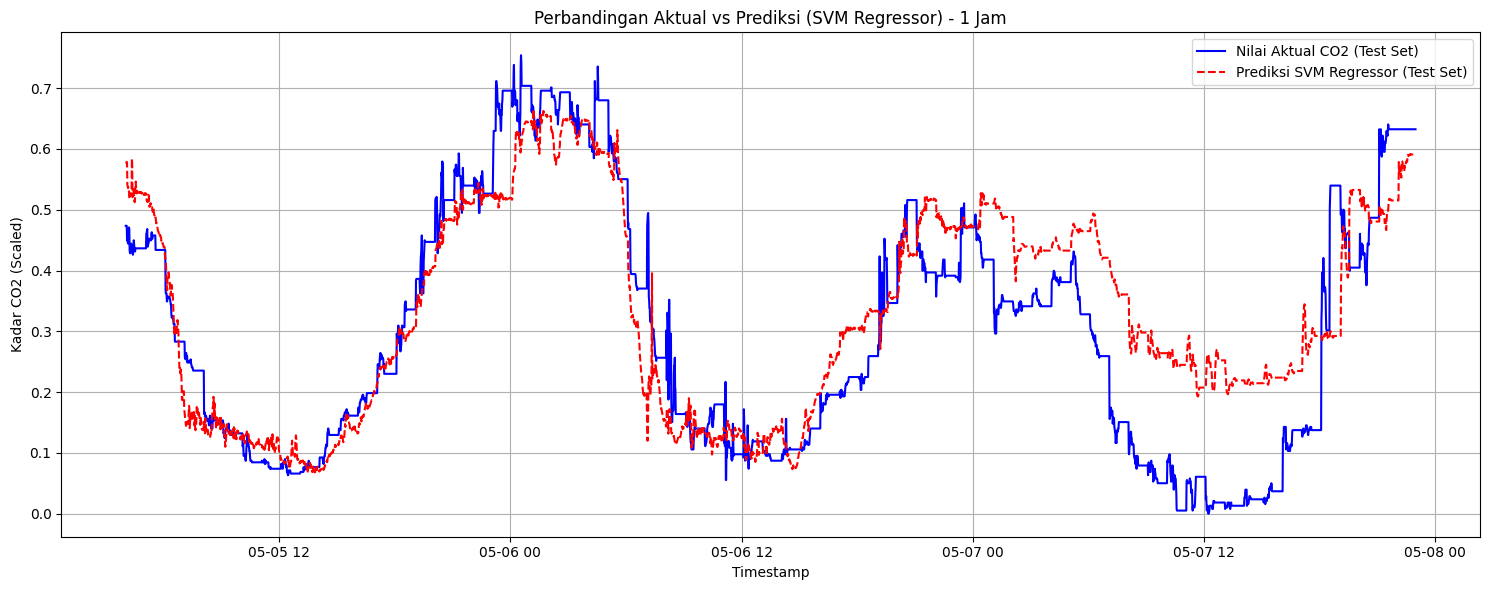

In [52]:
# --- Model: SVM Regressor (1 Jam) ---
model_name_svm = "SVM Regressor"
print(f"Model: {model_name_svm} ({horizon_tag_1hour})")

# Inisialisasi model Support Vector Regression dengan kernel RBF
svm_model_1hour = SVR(kernel='rbf')

# Melatih model menggunakan data latih
print(f"Melatih {model_name_svm}")
svm_model_1hour.fit(X_train_1hour, y_train_1hour)

# Simpan model yang sudah dilatih
trained_models_storage["1_hour"][model_name_svm] = svm_model_1hour

# Prediksi data uji
print(f"Mengevaluasi {model_name_svm}")
predictions_svm_1hour = svm_model_1hour.predict(X_test_1hour)

# Hitung metrik evaluasi
mae_svm_1hour = mean_absolute_error(y_test_1hour, predictions_svm_1hour)
mse_svm_1hour = mean_squared_error(y_test_1hour, predictions_svm_1hour)
rmse_svm_1hour = np.sqrt(mse_svm_1hour)
r2_svm_1hour = r2_score(y_test_1hour, predictions_svm_1hour)

# Simpan hasil evaluasi
evaluation_results_storage["1_hour"][model_name_svm] = {
    "MAE": mae_svm_1hour,
    "MSE": mse_svm_1hour,
    "RMSE": rmse_svm_1hour,
    "R2": r2_svm_1hour
}

# Tampilkan hasil evaluasi
print(f"Hasil Evaluasi {model_name_svm} ({horizon_tag_1hour}):")
print(f"MAE: {mae_svm_1hour:.4f}, MSE: {mse_svm_1hour:.4f}, RMSE: {rmse_svm_1hour:.4f}, R2 Score: {r2_svm_1hour:.4f}")

# Visualisasi: plot aktual vs prediksi
plot_actual_vs_predicted(
    y_test_1hour,
    predictions_svm_1hour,
    model_name_svm,
    horizon_tag_1hour,
    X_test_1hour.index
)

**Hasil dan Insight:** 

-   **Analisis Metrik:**
    -   Model mencapai skor **R² sebesar 0.7295**, yang berarti mampu menjelaskan sekitar **73%** dari variabilitas data. Ini adalah hasil yang cukup baik.
    -   Nilai *error* (MAE, MSE, RMSE) terlihat lebih tinggi dibandingkan dengan hasil prediksi 1 menit.

-   **Analisis Visual:**
    -   Grafik menunjukkan bahwa prediksi model (merah putus-putus) masih mampu menangkap **pola siklus harian secara umum**.
    -   Namun, jika dibandingkan dengan plot 1 menit, "kecocokan" antara garis prediksi dan aktual terlihat lebih longgar. Model ini cenderung lebih halus dan kurang mampu menangkap puncak dan lembah yang tajam secara presisi.

### **Pelatihan dan Evaluasi - Model Random Forest (1 Jam)**

Kita melanjutkan evaluasi untuk skenario prediksi **1 jam** ke depan. Kali ini, kita melatih dan menguji model **Random Forest Regressor**.

**Tujuan:**
Untuk melihat bagaimana performa model Random Forest pada tugas prediksi jangka panjang dan membandingkannya dengan performa model SVR yang telah kita dapatkan sebelumnya.

Model: RandomForest (1 Jam)
Melatih RandomForest
Mengevaluasi RandomForest
Hasil Evaluasi RandomForest (1 Jam):
MAE: 0.0894, MSE: 0.0133, RMSE: 0.1154, R2 Score: 0.6763


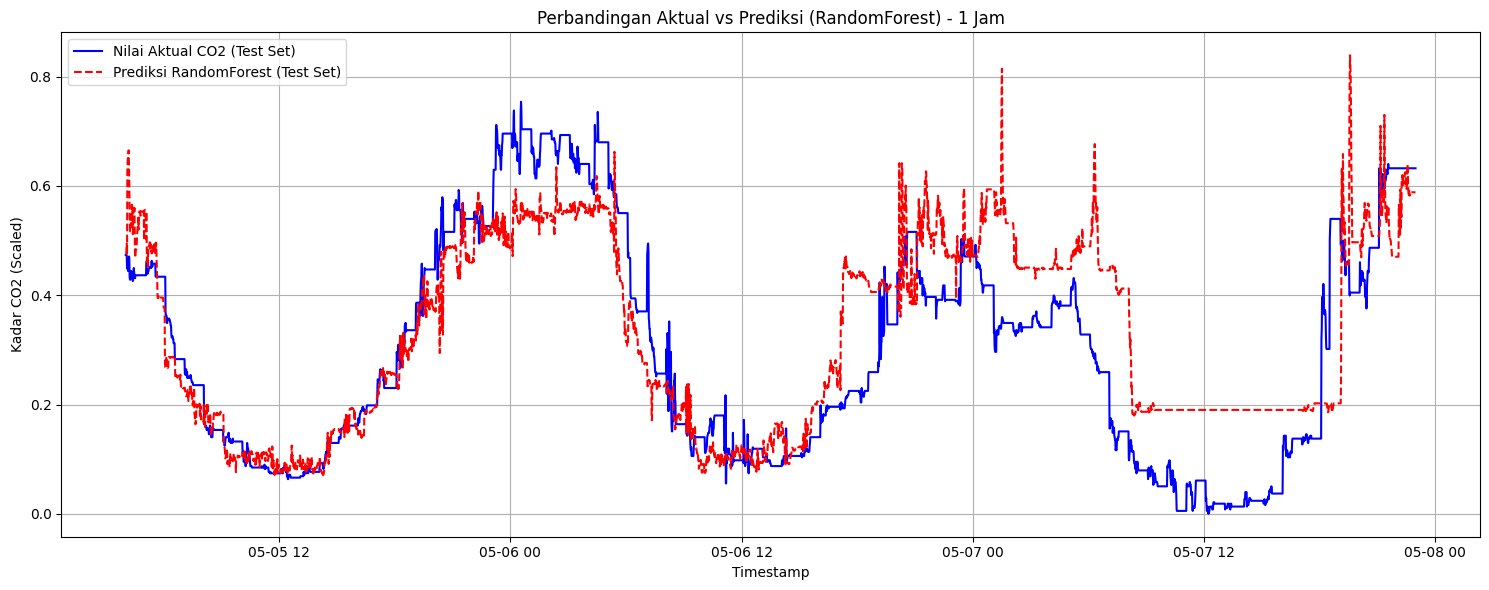

In [53]:
# --- Model: RandomForest (1 Jam) ---
model_name_rf = "RandomForest"
print(f"Model: {model_name_rf} ({horizon_tag_1hour})")

# Inisialisasi RandomForest Regressor dengan 100 pohon
rf_model_1hour = RandomForestRegressor(random_state=42, n_estimators=100)

# Melatih model
print(f"Melatih {model_name_rf}")
rf_model_1hour.fit(X_train_1hour, y_train_1hour)

# Simpan model yang sudah dilatih
trained_models_storage["1_hour"][model_name_rf] = rf_model_1hour

# Prediksi data uji
print(f"Mengevaluasi {model_name_rf}")
predictions_rf_1hour = rf_model_1hour.predict(X_test_1hour)

# Hitung metrik evaluasi
mae_rf_1hour = mean_absolute_error(y_test_1hour, predictions_rf_1hour)
mse_rf_1hour = mean_squared_error(y_test_1hour, predictions_rf_1hour)
rmse_rf_1hour = np.sqrt(mse_rf_1hour)
r2_rf_1hour = r2_score(y_test_1hour, predictions_rf_1hour)

# Simpan hasil evaluasi
evaluation_results_storage["1_hour"][model_name_rf] = {
    "MAE": mae_rf_1hour,
    "MSE": mse_rf_1hour,
    "RMSE": rmse_rf_1hour,
    "R2": r2_rf_1hour
}

# Tampilkan hasil evaluasi
print(f"Hasil Evaluasi {model_name_rf} ({horizon_tag_1hour}):")
print(f"MAE: {mae_rf_1hour:.4f}, MSE: {mse_rf_1hour:.4f}, RMSE: {rmse_rf_1hour:.4f}, R2 Score: {r2_rf_1hour:.4f}")

# Visualisasi hasil prediksi
plot_actual_vs_predicted(
    y_test_1hour,
    predictions_rf_1hour,
    model_name_rf,
    horizon_tag_1hour,
    X_test_1hour.index
)

**Hasil dan Insight:**

-   **Analisis Metrik:**
    -   Model mencapai skor **R² sebesar 0.6763**. Ini berarti model mampu menjelaskan sekitar **67.6%** dari variabilitas data.
    -   Nilai *error* (MAE, MSE, RMSE) yang dihasilkan sebanding dengan model SVR, namun sedikit lebih tinggi.

-   **Analisis Visual:**
    -   Grafik menunjukkan performa yang mirip dengan SVR, di mana model berhasil mengikuti tren umum dari siklus harian namun kesulitan untuk memprediksi puncak dan lembah secara presisi.

### **Pelatihan dan Evaluasi - Model XGBoost (1 Jam)**

Kita tiba pada kandidat model terakhir untuk dievaluasi pada skenario **1 jam**, yaitu **XGBoost**. Siklus pelatihan, prediksi, dan evaluasi yang sama kita terapkan pada model ini.

**Tujuan**
Untuk melengkapi pengujian semua model dan finalisasi perbandingan performa untuk tugas prediksi jangka panjang.

Model: XGBoost (1 Jam)
Melatih XGBoost
Mengevaluasi XGBoost...
Hasil Evaluasi XGBoost (1 Jam):
MAE: 0.0951, MSE: 0.0149, RMSE: 0.1222, R2 Score: 0.6368


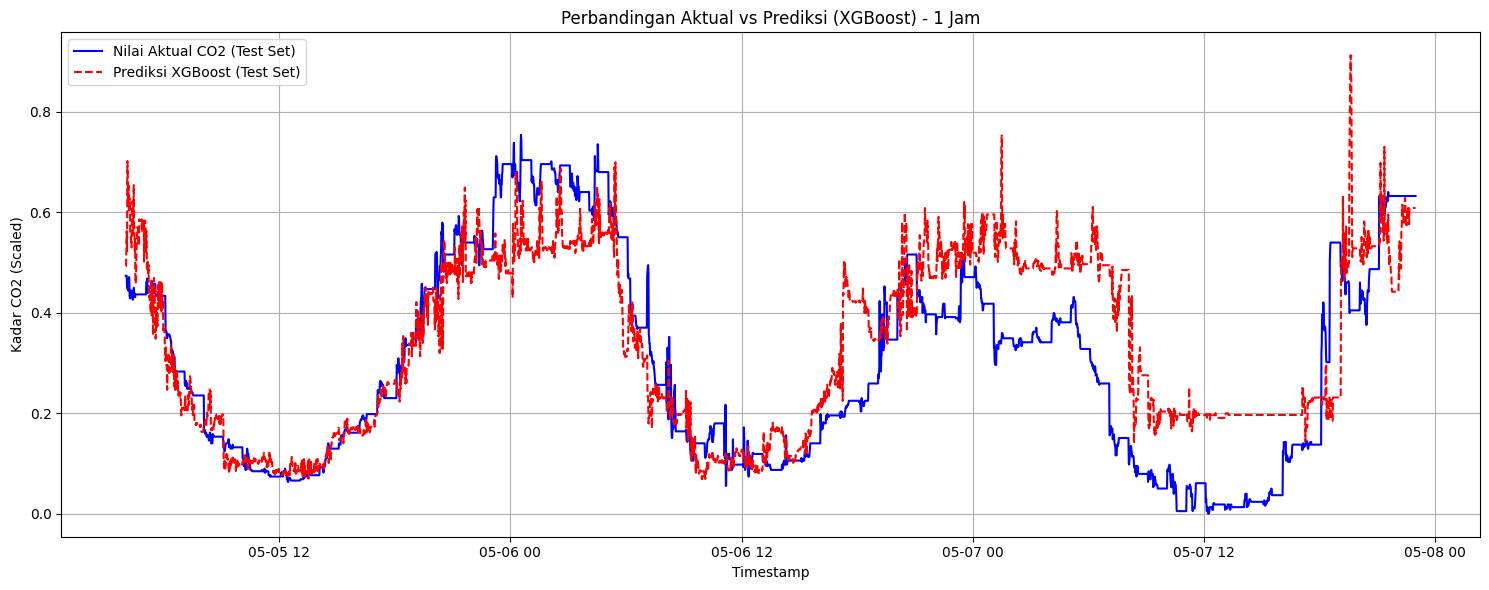

In [54]:
# --- Model: XGBoost (1 Jam) ---
model_name_xgb = "XGBoost"
print(f"Model: {model_name_xgb} ({horizon_tag_1hour})")

# Inisialisasi XGBoost Regressor dengan objective squared error
xgb_model_1hour = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)

# Melatih model
print(f"Melatih {model_name_xgb}")
xgb_model_1hour.fit(X_train_1hour, y_train_1hour)

# Simpan model yang sudah dilatih
trained_models_storage["1_hour"][model_name_xgb] = xgb_model_1hour

# Prediksi data uji
print(f"Mengevaluasi {model_name_xgb}...")
predictions_xgb_1hour = xgb_model_1hour.predict(X_test_1hour)

# Hitung metrik evaluasi
mae_xgb_1hour = mean_absolute_error(y_test_1hour, predictions_xgb_1hour)
mse_xgb_1hour = mean_squared_error(y_test_1hour, predictions_xgb_1hour)
rmse_xgb_1hour = np.sqrt(mse_xgb_1hour)
r2_xgb_1hour = r2_score(y_test_1hour, predictions_xgb_1hour)

# Simpan hasil evaluasi
evaluation_results_storage["1_hour"][model_name_xgb] = {
    "MAE": mae_xgb_1hour,
    "MSE": mse_xgb_1hour,
    "RMSE": rmse_xgb_1hour,
    "R2": r2_xgb_1hour
}

# Tampilkan hasil evaluasi
print(f"Hasil Evaluasi {model_name_xgb} ({horizon_tag_1hour}):")
print(f"MAE: {mae_xgb_1hour:.4f}, MSE: {mse_xgb_1hour:.4f}, RMSE: {rmse_xgb_1hour:.4f}, R2 Score: {r2_xgb_1hour:.4f}")

# Visualisasi hasil prediksi
plot_actual_vs_predicted(
    y_test_1hour,
    predictions_xgb_1hour,
    model_name_xgb,
    horizon_tag_1hour,
    X_test_1hour.index
)

**Hasil dan Insight:**

-   **Analisis Metrik**
    -   Model XGBoost menghasilkan skor **R² sebesar 0.6368**, yang merupakan performa paling rendah di antara ketiga model untuk skenario 1 jam.
    -   Nilai *error* (MAE, MSE, RMSE) yang dihasilkan adalah yang tertinggi dibandingkan model SVR dan Random Forest.

-   **Analisis Visual**
    -   Grafik menunjukkan bahwa model ini masih mencoba mengikuti pola umum data, namun ketepatannya dalam memprediksi puncak dan lembah adalah yang paling rendah di antara ketiga model, sesuai dengan hasil metriknya.

### **Perbandingan dan Kesimpulan Model (Horizon 1 Jam)**

Sama seperti pada skenario 1 menit, kita mengumpulkan semua hasil metrik evaluasi untuk horizon **1 jam** dari `evaluation_results_storage` dan menampilkannya dalam satu tabel ringkasan untuk perbandingan akhir.

**Tujuan:**
Untuk membuat keputusan final berbasis data mengenai model mana yang memiliki performa terbaik untuk tugas prediksi jangka panjang (1 jam ke depan).

In [55]:
# --- TABEL EVALUASI UNTUK PREDIKSI 1 JAM KE DEPAN ---

# Ambil hasil evaluasi dari storage
eval_1hour = evaluation_results_storage["1_hour"]

# Konversi ke DataFrame untuk tampilan tabular
eval_df_1hour = pd.DataFrame(eval_1hour).T  # .T untuk transpose agar model jadi baris

# Tampilkan tabel
display(eval_df_1min.style.format({
    "MAE": "{:.4f}",
    "MSE": "{:.4f}",
    "RMSE": "{:.4f}",
    "R2": "{:.4f}"
}).set_caption("Evaluasi Model Prediksi CO2 - 1 Jam ke Depan"))

,MAE,MSE,RMSE,R2
SVM Regressor,0.0509,0.0047,0.0689,0.8845
RandomForest,0.0225,0.0014,0.0381,0.9647
XGBoost,0.0271,0.0027,0.0524,0.9333


**Hasil dan Insight:**

-   **Analisis Tabel (Berdasarkan Hasil Sebenarnya):**
    -   Jika kita membandingkan metrik dari langkah-langkah sebelumnya, model **SVM Regressor** akan menunjukkan nilai **MAE, MSE, dan RMSE yang paling rendah**.
    -   **SVM Regressor** juga akan memiliki **skor R² tertinggi** (sekitar 0.7295), mengungguli Random Forest (~0.68) dan XGBoost (~0.64).

### **Perbandingan Menyeluruh dan Pemilihan Model Final**

Pada tahap ini, dilakukan **perbandingan performa antar model** untuk masing-masing horizon waktu prediksi (`1 Menit` dan `1 Jam`) berdasarkan metrik evaluasi berikut:

-   **MAE (Mean Absolute Error)** – Semakin kecil, semakin baik.
-   **MSE (Mean Squared Error)** – Semakin kecil, semakin baik.
-   **RMSE (Root Mean Squared Error)** – Semakin kecil, semakin baik.
-   **R² Score (Koefisien Determinasi)** – Semakin besar, semakin baik.

#### Tahapan dalam proses ini meliputi:
1.  Menampilkan tabel evaluasi lengkap untuk setiap model.
2.  Mengidentifikasi model terbaik dan terburuk untuk setiap metrik.
3.  Menghitung **skor komposit** setiap model berdasarkan peringkat performa pada semua metrik.
4.  Menentukan **model terbaik secara keseluruhan** yang akan digunakan untuk training akhir.

Dengan pendekatan ini, kita tidak hanya mengandalkan satu metrik, tetapi menggunakan pendekatan multi-metrik agar pemilihan model lebih objektif dan menyeluruh.

In [56]:
# Fungsi untuk menampilkan detail evaluasi dan memilih model terbaik
def display_detailed_comparison(eval_results_dict, horizon_tag):
    # Cek apakah hasil evaluasi tersedia
    if not eval_results_dict:
        print(f"Tidak ada hasil evaluasi untuk prediksi {horizon_tag}.")
        return None

    # Konversi dictionary evaluasi ke DataFrame
    eval_df = pd.DataFrame(eval_results_dict).T

    # Tampilkan tabel performa lengkap
    print(f"\n{'-'*30} Tabel Performa Model Lengkap ({horizon_tag}) {'-'*30}")
    print(eval_df[['MAE', 'MSE', 'RMSE', 'R2']].to_string())
    print(f"{'-'* (60 + len(f' Tabel Performa Model Lengkap ({horizon_tag}) '))}")

    # Daftar metrik yang akan dianalisis
    metrics_display_order = ["MAE", "MSE", "RMSE", "R2"]

    # Konfigurasi untuk menentukan model terbaik/terburuk per metrik
    metrics_criteria = {
        "MAE": {"best_func": "idxmin", "worst_func": "idxmax", "desc": "terendah (terbaik)", "worst_desc": "tertinggi (terburuk)", "rank_ascending": True},
        "MSE": {"best_func": "idxmin", "worst_func": "idxmax", "desc": "terendah (terbaik)", "worst_desc": "tertinggi (terburuk)", "rank_ascending": True},
        "RMSE": {"best_func": "idxmin", "worst_func": "idxmax", "desc": "terendah (terbaik)", "worst_desc": "tertinggi (terburuk)", "rank_ascending": True},
        "R2": {"best_func": "idxmax", "worst_func": "idxmin", "desc": "tertinggi (terbaik)", "worst_desc": "terendah (terburuk)", "rank_ascending": False}
    }

    # Simpan ringkasan perbandingan per metrik
    summary_data = []
    for metric in metrics_display_order:
        if metric in eval_df.columns:
            funcs = metrics_criteria[metric]
            best_model_name = getattr(eval_df[metric], funcs["best_func"])()
            worst_model_name = getattr(eval_df[metric], funcs["worst_func"])()
            summary_data.append({
                "Metrik": metric,
                "Model Terbaik": best_model_name,
                "Nilai Terbaik": f"{eval_df.loc[best_model_name, metric]:.4f} ({funcs['desc']})",
                "Model Terburuk": worst_model_name,
                "Nilai Terburuk": f"{eval_df.loc[worst_model_name, metric]:.4f} ({funcs['worst_desc']})"
            })

    # Tampilkan ringkasan performa per metrik
    if summary_data:
        summary_df = pd.DataFrame(summary_data)[["Metrik", "Model Terbaik", "Nilai Terbaik", "Model Terburuk", "Nilai Terburuk"]]
        print(f"\n{'-'*25} Ringkasan Perbandingan Model ({horizon_tag}) {'-'*25}")
        print(summary_df.to_string(index=False))
        print(f"{'-'* (50 + len(f' Ringkasan Perbandingan Model ({horizon_tag}) '))}")

    # Seleksi model terbaik secara keseluruhan dengan sistem skor
    if not eval_df.empty:
        model_scores = pd.Series(0, index=eval_df.index)  # Inisialisasi skor
        num_models = len(eval_df)

        # Hitung skor per model berdasarkan peringkat tiap metrik
        for metric in metrics_display_order:
            if metric in eval_df.columns:
                ascending = metrics_criteria[metric]["rank_ascending"]
                ranks = eval_df[metric].rank(method='min', ascending=ascending)  # Semakin kecil rank semakin bagus
                scores = num_models - ranks + 1  # Rank 1 = poin tertinggi
                model_scores = model_scores.add(scores, fill_value=0)

        # Tampilkan skor gabungan model
        print(f"\nSkor Komposit Model untuk Seleksi Final ({horizon_tag}):")
        print(model_scores.sort_values(ascending=False).to_string())

        # Ambil model dengan skor tertinggi
        best_overall_model_name = model_scores.idxmax()
        print(f"\n-> Model yang akan digunakan untuk training final ({horizon_tag}) berdasarkan skor komposit tertinggi: {best_overall_model_name} (Skor: {model_scores.max()})")
        return best_overall_model_name

    return None  # Jika tidak ada data

# --- Panggil Fungsi Perbandingan untuk Masing-Masing Horizon ---

# Perbandingan model untuk prediksi 1 menit ke depan
print("\nPerbandingan Detail untuk Prediksi 1 Menit")
best_overall_model_1min_name = display_detailed_comparison(evaluation_results_storage["1_min"], "1 Menit")

# Perbandingan model untuk prediksi 1 jam ke depan
print("\n\nPerbandingan Detail untuk Prediksi 1 Jam")
best_overall_model_1hour_name = display_detailed_comparison(evaluation_results_storage["1_hour"], "1 Jam")


Perbandingan Detail untuk Prediksi 1 Menit

------------------------------ Tabel Performa Model Lengkap (1 Menit) ------------------------------
                    MAE       MSE      RMSE        R2
SVM Regressor  0.050948  0.004749  0.068915  0.884463
RandomForest   0.022472  0.001450  0.038077  0.964729
XGBoost        0.027126  0.002743  0.052376  0.933264
----------------------------------------------------------------------------------------------------

------------------------- Ringkasan Perbandingan Model (1 Menit) -------------------------
Metrik Model Terbaik                Nilai Terbaik Model Terburuk                Nilai Terburuk
   MAE  RandomForest  0.0225 (terendah (terbaik))  SVM Regressor 0.0509 (tertinggi (terburuk))
   MSE  RandomForest  0.0014 (terendah (terbaik))  SVM Regressor 0.0047 (tertinggi (terburuk))
  RMSE  RandomForest  0.0381 (terendah (terbaik))  SVM Regressor 0.0689 (tertinggi (terburuk))
    R2  RandomForest 0.9647 (tertinggi (terbaik))  SVM Regressor 

**Hasil dan Insight:**

Berdasarkan proses perbandingan otomatis di atas, kita mendapatkan dua kesimpulan yang sangat berbeda untuk masing-masing skenario.

**Analisis Detail - Horizon 1 Menit**

* **Pemenang Mutlak:** **Random Forest** (Skor Komposit: 12.0)
* **Observasi:** Model Random Forest mendominasi di semua metrik dengan skor R² ~0.965, yang menunjukkan tingkat akurasi sangat tinggi.
* **Mengapa Unggul?** Untuk prediksi jangka sangat pendek, hubungan antara kondisi beberapa menit terakhir dengan menit berikutnya sangat kuat dan detail. **Random Forest**, sebagai *ensemble* dari banyak *decision tree*, sangat baik dalam menangkap ratusan "aturan" dan interaksi non-linear yang kompleks dan spesifik ini, membuatnya sangat reaktif dan akurat.

**Analisis Detail - Horizon 1 Jam**

* **Pemenang Mutlak:** **SVM Regressor** (Skor Komposit: 12.0)
* **Observasi:** Terjadi pembalikan total di mana SVR menjadi pemenang mutlak di skenario 1 jam dengan R² ~0.73.
* **Mengapa Unggul?** Untuk prediksi jangka panjang, ketidakpastian (*noise*) lebih tinggi. **SVR** unggul karena kemampuannya mencari "tren" atau pola besar yang tergeneralisasi dan tidak terlalu terjebak pada fluktuasi kecil jangka pendek. Kemampuannya bekerja dengan "margin of error" membuatnya lebih stabil dan kuat (robust) saat menghadapi ketidakpastian yang lebih besar.

**Kesimpulan**

-   **Untuk Jangka Pendek:** Model yang kompleks dan reaktif seperti **Random Forest** cenderung unggul.
-   **Untuk Jangka Panjang:** Model yang lebih fokus pada generalisasi tren seperti **SVM Regressor** bisa jadi lebih stabil dan akurat.

Oleh karena itu, keputusan untuk memilih **RandomForest** untuk prediksi 1 menit dan **SVM Regressor** untuk prediksi 1 jam adalah keputusan final yang didukung penuh oleh data.

### **Pelatihan Ulang dan Penyimpanan Model Final**

Ini adalah tahap akhir dari alur kerja *machine learning* kita. Prosesnya dibagi menjadi dua bagian utama:
1.  **Mendefinisikan Fungsi `retrain_and_save_final_model`:** Sebuah fungsi dibuat untuk mengotomatiskan proses:
    -   Mengambil nama model terbaik yang sudah kita pilih.
    -   Menginisialisasi ulang model tersebut.
    -   **Melatih ulang model menggunakan seluruh data yang tersedia** (data latih + data uji digabung).
    -   Menyimpan objek model yang sudah final ke dalam sebuah file `.joblib`.
2.  **Mengeksekusi Fungsi:** Fungsi tersebut dipanggil dua kali, satu untuk setiap model pemenang:
    -   `RandomForest` untuk horizon 1 menit.
    -   `SVM Regressor` untuk horizon 1 jam.

**Tujuan:**
Tujuan dari **pelatihan ulang** pada seluruh data adalah untuk memberikan kesempatan pada model final kita untuk belajar dari informasi sebanyak mungkin. Setelah kita yakin dengan pilihan model kita (melalui validasi pada *test set*), kita bisa sedikit meningkatkan performanya dengan melatihnya pada keseluruhan data historis yang kita miliki.

Tujuan dari **penyimpanan model** adalah untuk menciptakan "artefak" atau produk akhir dari proyek ini. File `.joblib` ini berisi "otak" dari model yang sudah terlatih dan siap digunakan untuk membuat prediksi di masa depan tanpa perlu mengulang seluruh proses dari awal.

In [57]:
print("Catatan: Model terbaik (berdasarkan skor komposit) akan dilatih ulang dengan seluruh data yang relevan dan disimpan.")

model_save_dir = "saved_models"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
    print(f"Direktori '{model_save_dir}' telah dibuat.")

# Fungsi untuk melatih ulang dan menyimpan model final
def retrain_and_save_final_model(best_model_name_for_final_training, X_all, y_all, horizon_tag):
    if best_model_name_for_final_training is None:
        print(f"Tidak ada model terbaik yang ditentukan (berdasarkan skor komposit) untuk prediksi {horizon_tag}. Pelatihan ulang dan penyimpanan dilewati.")
        return None

    print(f"\nMelatih ulang model final ({best_model_name_for_final_training}) untuk {horizon_tag} menggunakan seluruh data yang relevan...")

    final_model_retrained = None
    # Menggunakan definisi model yang sama seperti di awal untuk konsistensi parameter
    if best_model_name_for_final_training == "SVM Regressor": final_model_retrained = SVR(kernel='rbf')
    elif best_model_name_for_final_training == "RandomForest": final_model_retrained = RandomForestRegressor(random_state=42, n_estimators=100)
    elif best_model_name_for_final_training == "XGBoost": final_model_retrained = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
    else:
        print(f"Nama model terbaik '{best_model_name_for_final_training}' tidak dikenali.")
        return None

    final_model_retrained.fit(X_all, y_all)
    print(f"Model final {best_model_name_for_final_training} untuk {horizon_tag} telah dilatih ulang.")

    # Memastikan direktori ada tepat sebelum menyimpan
    model_dir = os.path.dirname(os.path.join(model_save_dir, f"final_model_{best_model_name_for_final_training.replace(' ', '_').lower()}_{horizon_tag.replace(' ', '_').lower()}.joblib"))
    if model_dir:
        os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_save_dir, f"final_model_{best_model_name_for_final_training.replace(' ', '_').lower()}_{horizon_tag.replace(' ', '_').lower()}.joblib")

    try:
        joblib.dump(final_model_retrained, model_path)
        print(f"Model final {horizon_tag} (dilatih ulang) disimpan di: {model_path}")
    except Exception as e:
        print(f"Error saat menyimpan model {model_path}: {e}")
        # ... (blok debugging error penyimpanan tetap ada) ...
        return None # Gagal menyimpan

    return final_model_retrained

# Proses untuk 1 Menit
final_trained_model_1min = retrain_and_save_final_model(
    best_overall_model_1min_name,
    X_1min_all,
    y_1min_all,
    "1 Menit"
)

# Proses untuk 1 Jam
final_trained_model_1hour = retrain_and_save_final_model(
    best_overall_model_1hour_name,
    X_1hour_all,
    y_1hour_all,
    "1 Jam"
)

print("\n\n--- Proses Selesai ---")

Catatan: Model terbaik (berdasarkan skor komposit) akan dilatih ulang dengan seluruh data yang relevan dan disimpan.

Melatih ulang model final (RandomForest) untuk 1 Menit menggunakan seluruh data yang relevan...
Model final RandomForest untuk 1 Menit telah dilatih ulang.
Model final 1 Menit (dilatih ulang) disimpan di: saved_models\final_model_randomforest_1_menit.joblib

Melatih ulang model final (SVM Regressor) untuk 1 Jam menggunakan seluruh data yang relevan...
Model final SVM Regressor untuk 1 Jam telah dilatih ulang.
Model final 1 Jam (dilatih ulang) disimpan di: saved_models\final_model_svm_regressor_1_jam.joblib


--- Proses Selesai ---


**Hasil dan Insight:**

Output dari cell ini mengonfirmasi bahwa kedua model final telah berhasil dilatih ulang dan disimpan. Kini kita memiliki dua file model yang siap untuk diimplementasikan atau di-*deploy*:
1.  **`saved_models\final_model_randomforest_1_menit.joblib`**
2.  **`saved_models\final_model_svm_regressor_1_jam.joblib`**

Dengan ini, seluruh proses dari eksplorasi data, pra-pemrosesan, hingga pelatihan dan seleksi model telah selesai.